# Сравнение бустинговых моделей. Описание проекта.

Ссылка на Kaggle: https://www.kaggle.com/datasets/hopesb/student-depression-dataset

В этом датасете собраны данные об учащихся, исследуемым бинарным признаком является наличие у них у диагностированной депрессии (столбец Depression, значение 1 - есть депрессия, значение 0 -депрессии нет). Входными признаками является собранная о них информация:
- Gender - пол;
- Age - возраст;
-	City - город проживания;
-	Profession - профессия;
-	Academic Pressure - учебная нагрузка;
-	Work Pressure - рабочая нагрузка;
-	CGPA - это Cumulative Grade Point Average (средний кумулятивный балл). Для школ и колледжей CGPA используется для измерения общей академической успеваемости учащегося путем присвоения оценок A, B, C, D или F. CGPA — это  расчет среднего балла, полученного по всем предметам, за исключением дополнительных предметов в соответствии со схемой обучения;
-	Study Satisfaction  - оцнека удовлетворённости учёбой;
-	Job Satisfaction - оценка удовлетворённости работой;
-	Sleep Duration - длительность сна;
-	Dietary Habits - пищевые привычки;
-	Degree  - учёная степень;
-	Have you ever had suicidal thoughts ? - Были ли когда-то суицидальные мысли (1 - да, 0 - нет)
-	Work/Study Hours - учебные/рабочие часы;
-	Financial Stress - оцнека финансового стресса;
-	Family History of Mental Illness - есть ли родственники, имеющие проблемы с ментальным здоровьем (1-есть, 0 -нет).

Предсказывать наличие депресси у учащегося будем путём бинарной классифкации с помощью бустинговых моделей: XGBoost, LightGBM и Catboost. Сравнивать их успешность работы с данным датасетом будем по метрике F1.


# Загрузка данных.

Загружаем данные напрямую с Kaggle.

In [1]:
import kagglehub

path = kagglehub.dataset_download('hopesb/student-depression-dataset')

print('Path to dataset files:', path)

Path to dataset files: /root/.cache/kagglehub/datasets/hopesb/student-depression-dataset/versions/1


Загружаем требуемые библиотеки.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install catboost
from catboost import CatBoostClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

!pip install scikit-learn==1.3.1 xgboost --upgrade #иначе появлялись ошибки в процессе выполнения

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

!pip install optuna
import optuna

import joblib

!pip install phik
from phik import report
from phik.report import plot_correlation_matrix

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Фиксируем переменную для Random State.

In [3]:
RNDM_STATE = 42

Открываем данные, смотрим.

In [4]:
df= pd.read_csv(path + '/Student Depression Dataset.csv')
df.sample(5)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
1457,7494,Male,28.0,Ghaziabad,Student,3.0,0.0,7.28,3.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,6.0,5.0,No,1
27038,136295,Female,22.0,Vasai-Virar,Student,1.0,0.0,5.78,1.0,0.0,Less than 5 hours,Unhealthy,BE,No,7.0,4.0,No,0
3734,18705,Male,24.0,Ahmedabad,Student,1.0,0.0,8.88,1.0,0.0,Less than 5 hours,Healthy,B.Com,No,7.0,3.0,Yes,1
15689,79257,Male,34.0,Surat,Student,5.0,0.0,5.27,5.0,0.0,Less than 5 hours,Moderate,BCA,Yes,3.0,1.0,No,1
19119,96840,Male,26.0,Kalyan,Student,3.0,0.0,6.76,1.0,0.0,7-8 hours,Healthy,B.Ed,Yes,8.0,3.0,No,0


## Выводы по разделу.

Данные и библиотеки для дальнейшей работы с ними загружены, можно приступать к выполнению проекта.

# Исследование данных.

Вызовем основную информацию о датафрейме.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

Видим, что пропусков в данных нет.

In [6]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


Столбец с айдишниками нам не понадобится, поэтому избавляемся от него прямо сейчас

In [7]:
df = df.drop('id', axis=1)

Смотрим разброс значений по числовым признакам.

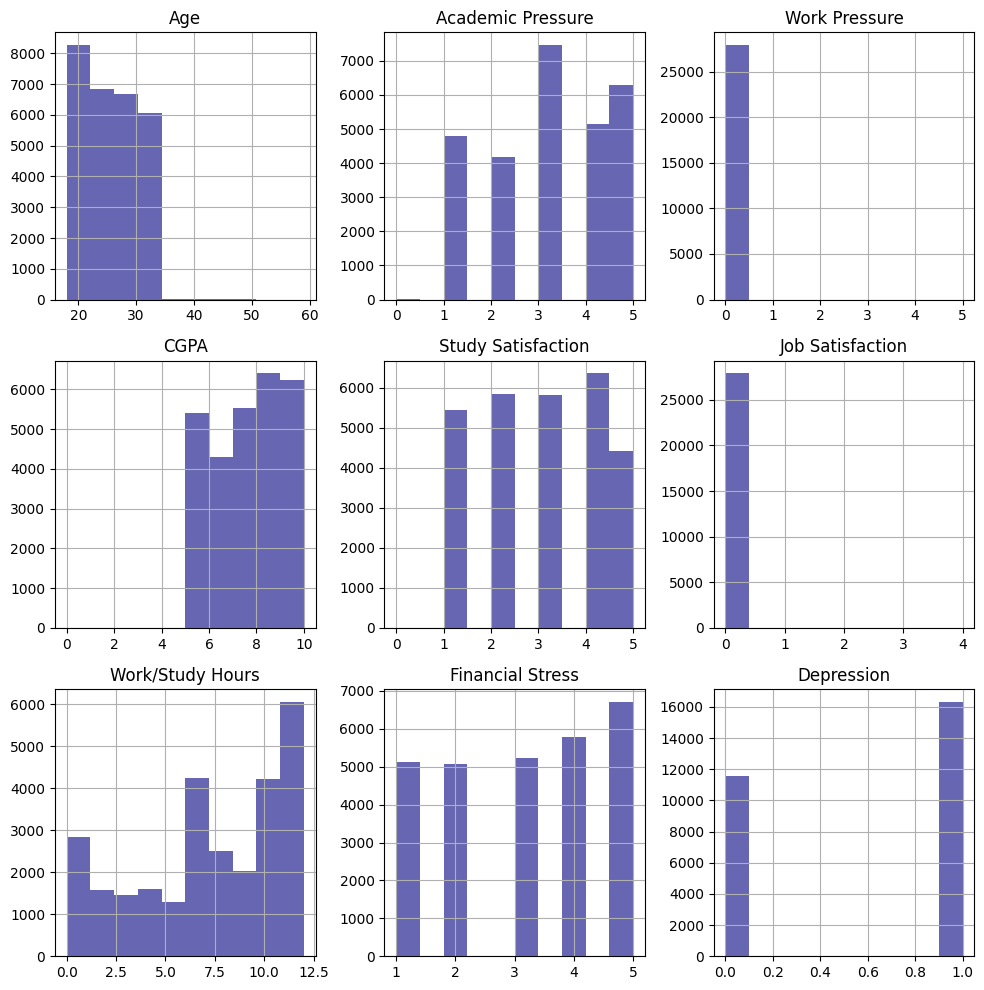

In [8]:
df.hist(figsize=(10, 10), color='navy', alpha = 0.6)
plt.tight_layout()
plt.show()

Смотрим, как распределяются по полу учащиеся в нашем датасете.

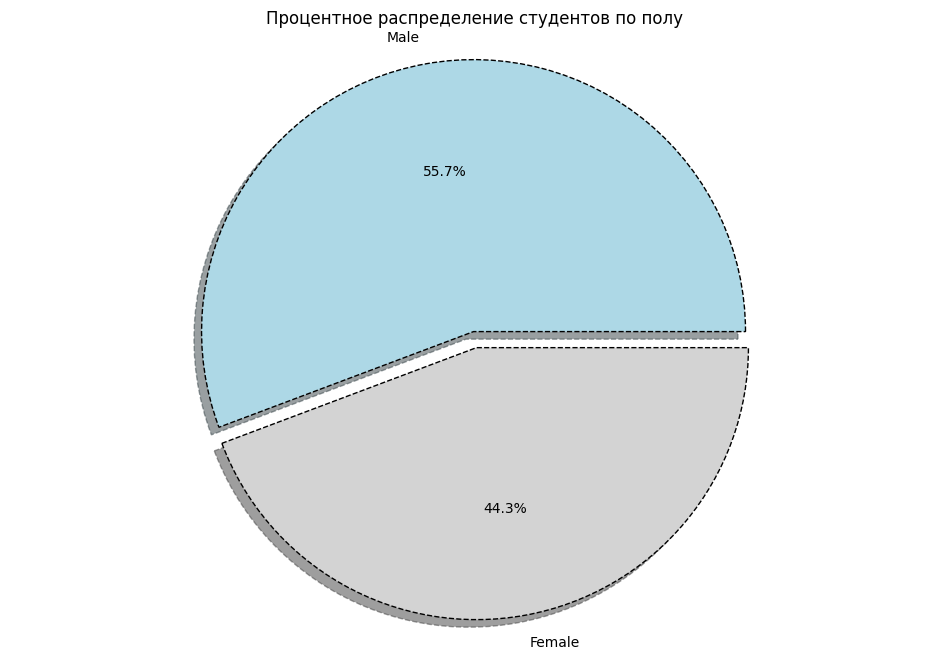

In [9]:
counts = df['Gender'].value_counts()

explode = [0.05, 0.01] + [0] * (len(counts) - 3)
plt.figure(figsize=(12, 8))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    colors=['lightblue', 'lightgrey'] + ['C0'] * (len(counts) - 3),
    wedgeprops={'lw': 1, 'ls': '--', 'edgecolor': 'k'},
)
plt.axis('equal')
plt.title('Процентное распределение студентов по полу')
plt.show()

Отделим числовые признаки от категориальных. Запишем их с названиями в формате словаря, дабы потом брать из него описания для графиков.

In [10]:
numerical_features = {
    'Age': 'Возраст',
    'Academic Pressure': 'Учебная нагрузка',
    'Work Pressure': 'Рабочая нагрузка',
    'CGPA': 'Средний балл',
    'Study Satisfaction': 'Удовлетворённость учёбой',
    'Job Satisfaction': 'Удовлетворённость работой',
    'Work/Study Hours': 'Учебные/рабочие часы',
    'Financial Stress': 'Финансовый стресс'
}

categorical_features = {
    'Gender': 'Пол',
    'City': 'Город',
    'Profession': 'Профессия',
    'Sleep Duration': 'Длительность сна',
    'Dietary Habits': 'Пищевые привычки',
    'Degree': 'Учёная степень',
    'Have you ever had suicidal thoughts ?': 'Были ли когда-то суицидальные мысли',
    'Family History of Mental Illness': 'Есть ли родственники с ментальными расстройствами'
}

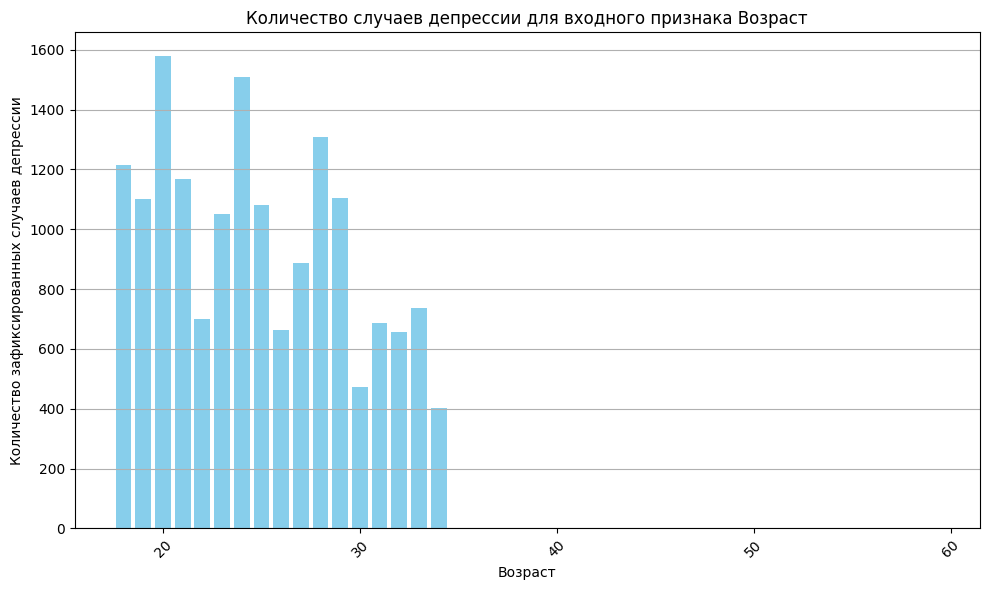

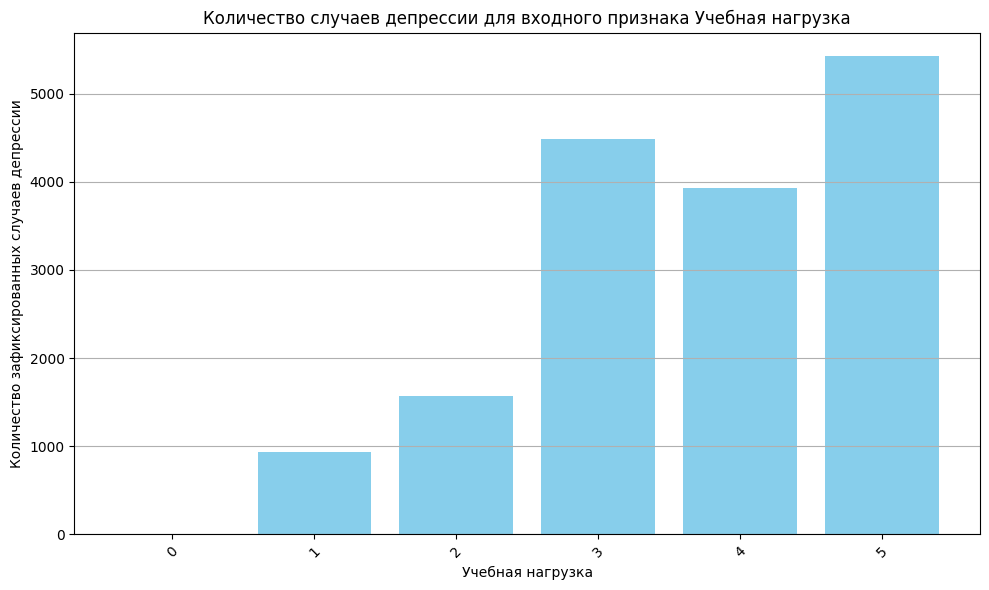

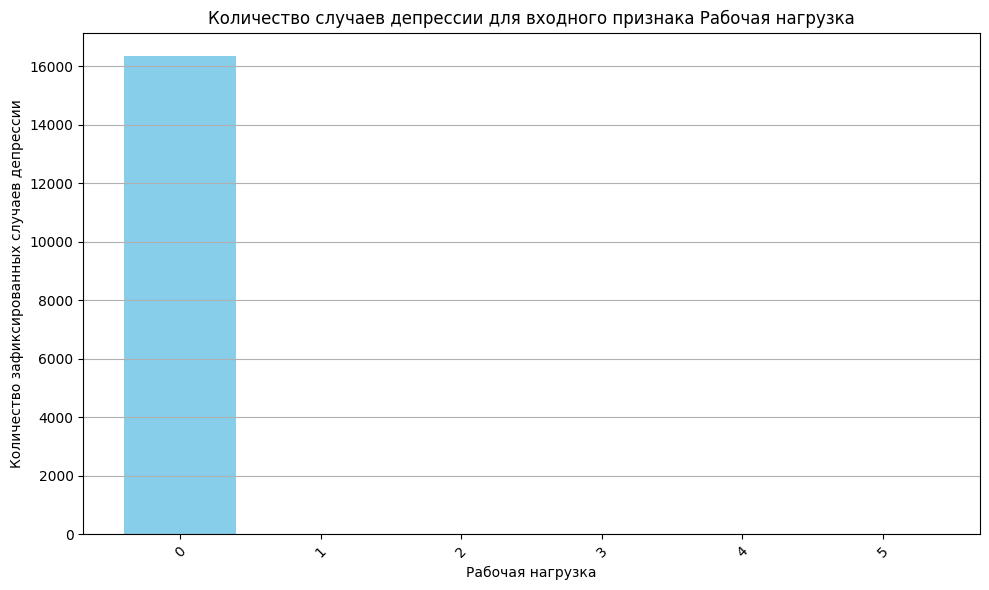

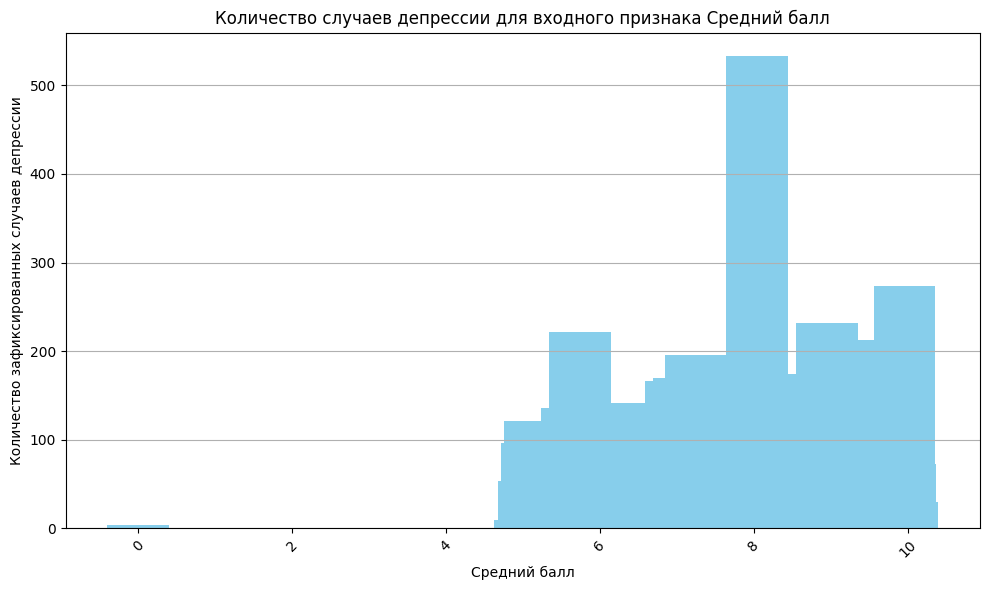

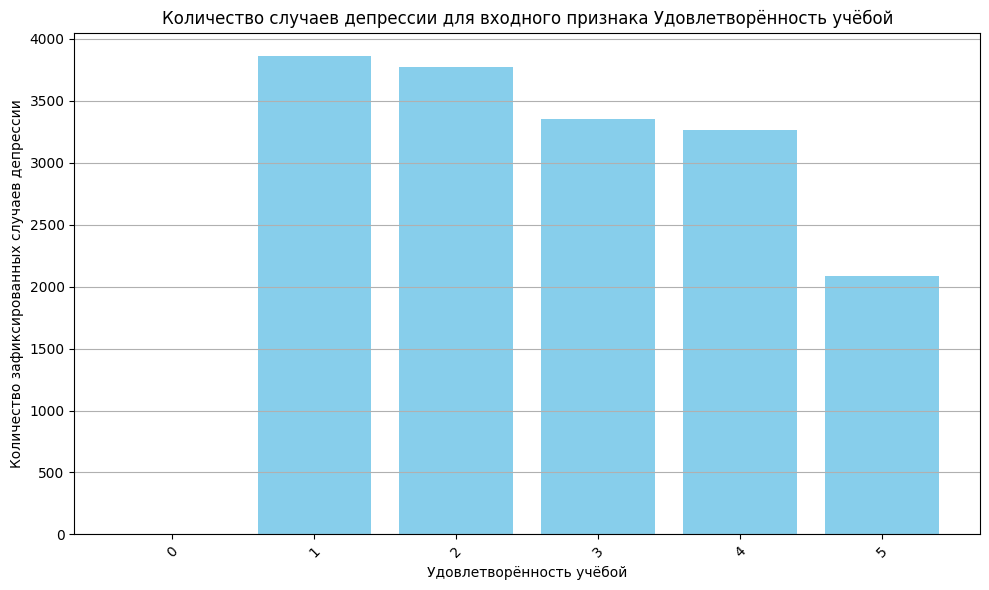

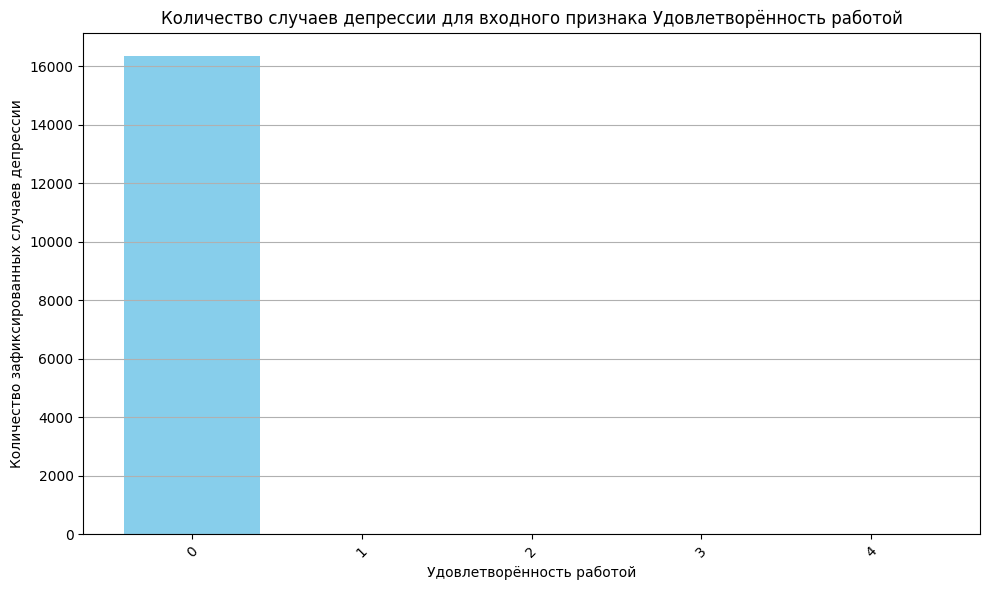

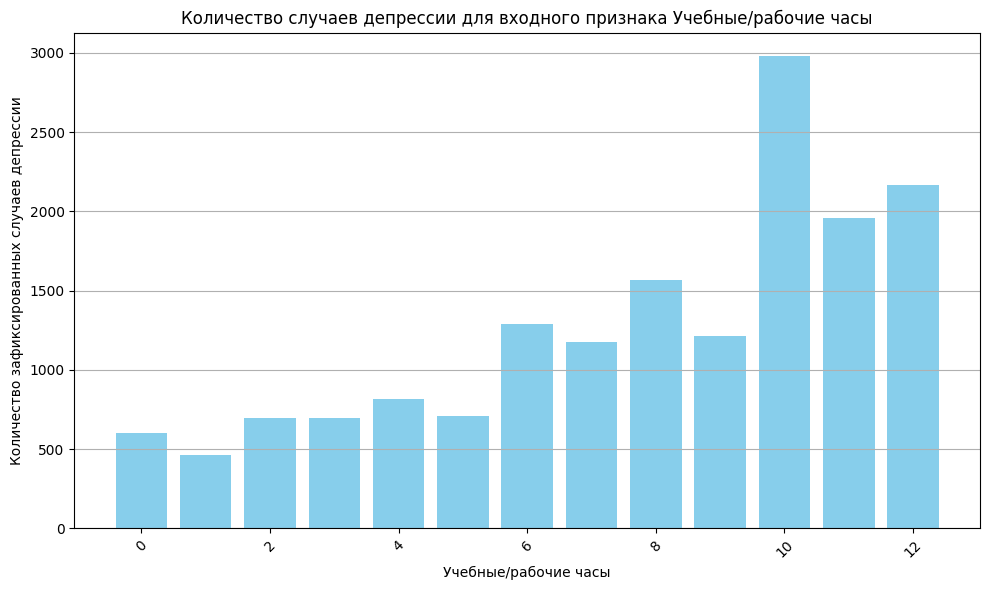

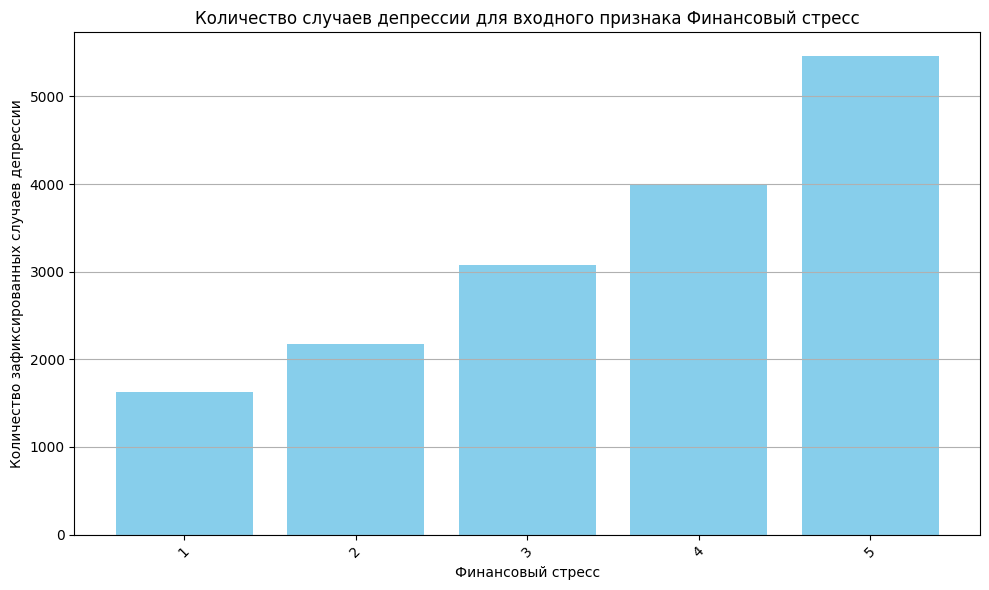

In [11]:
for feature in numerical_features.keys():

    pivot_table = df.groupby(feature)['Depression'].sum().reset_index()

    plt.figure(figsize=(10, 6))
    plt.bar(pivot_table[feature], pivot_table['Depression'], color='skyblue')

    plt.title(
        f'Количество случаев депрессии для входного признака {numerical_features[feature]}'
    )
    plt.xlabel(numerical_features[feature])
    plt.ylabel('Количество зафиксированных случаев депрессии')

    plt.xticks(rotation=45)

    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    print(' ')


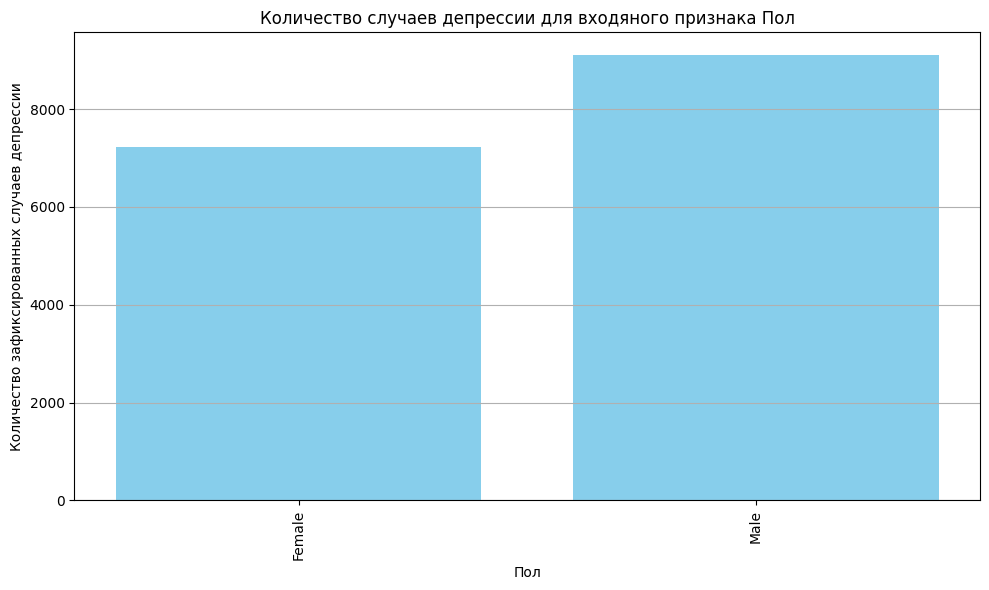

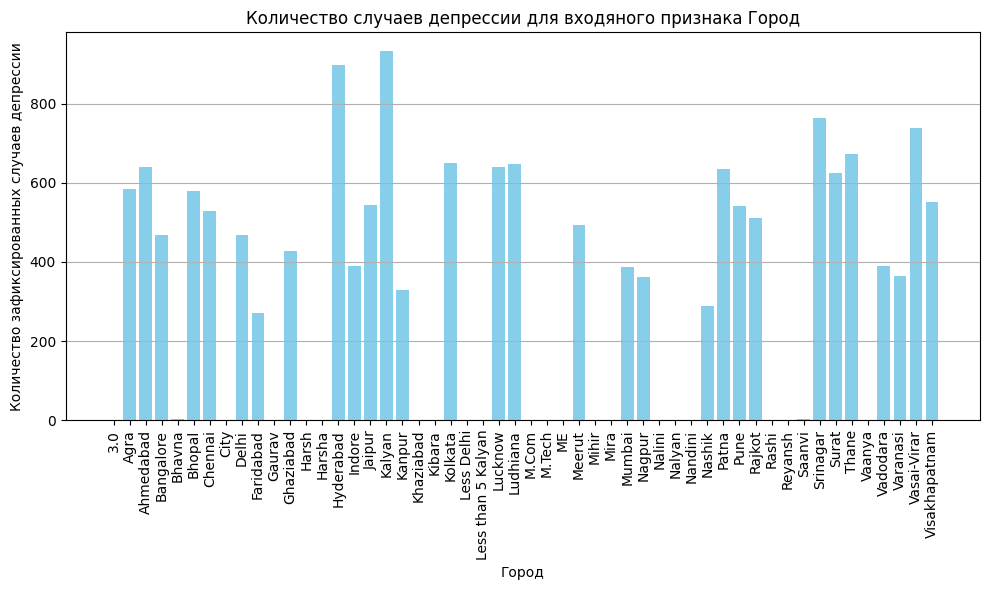

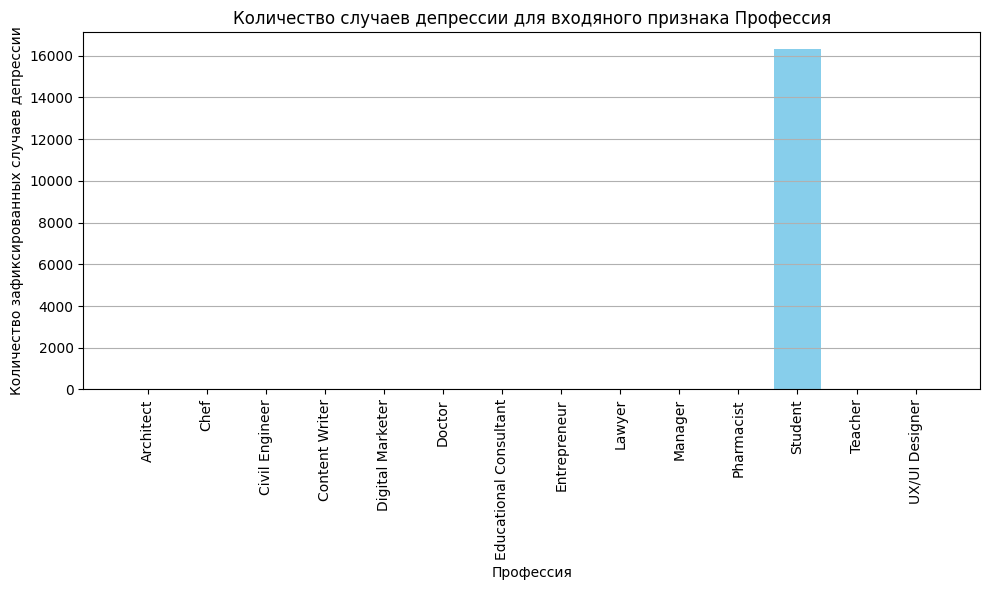

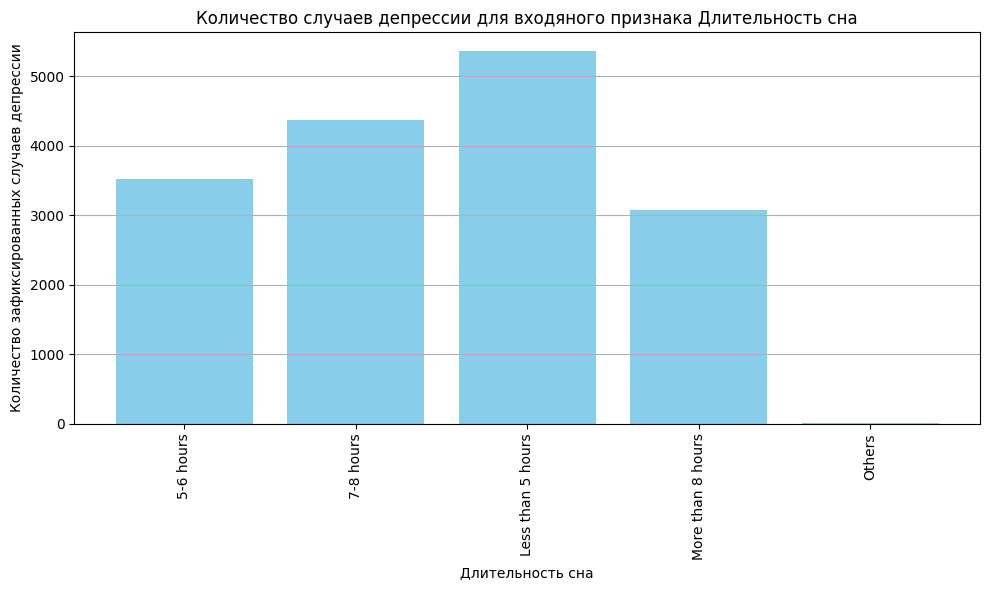

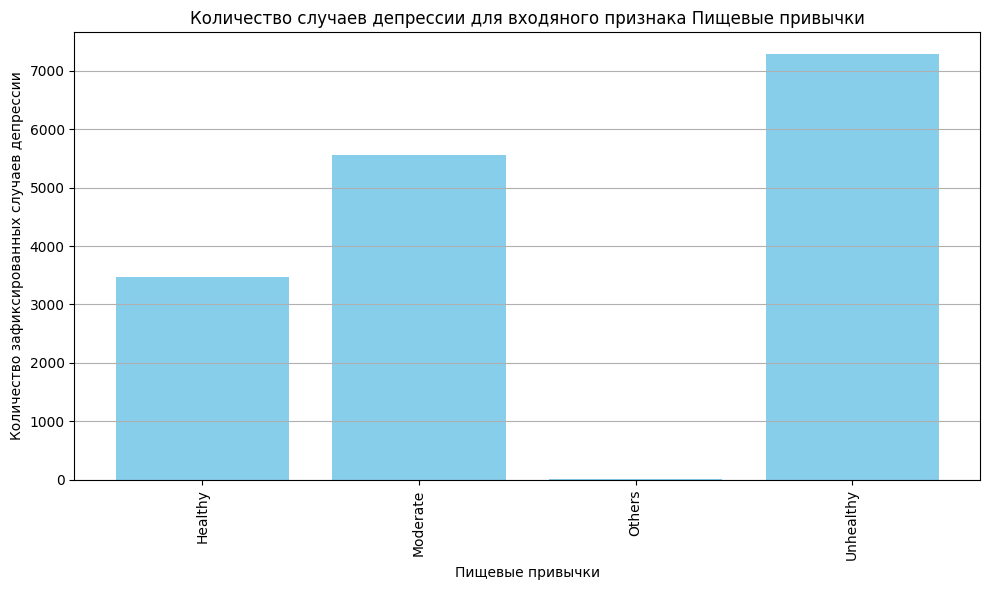

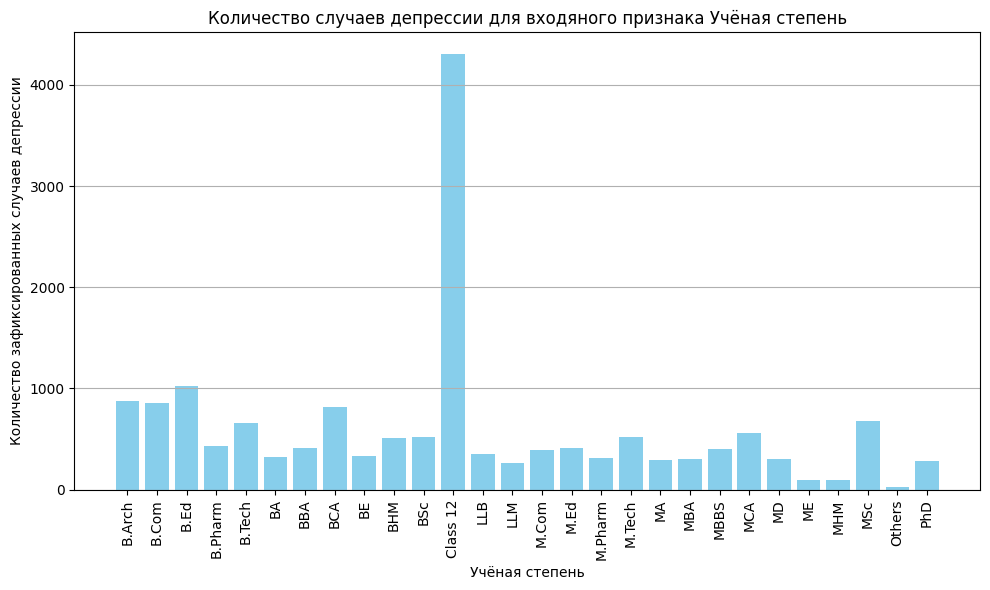

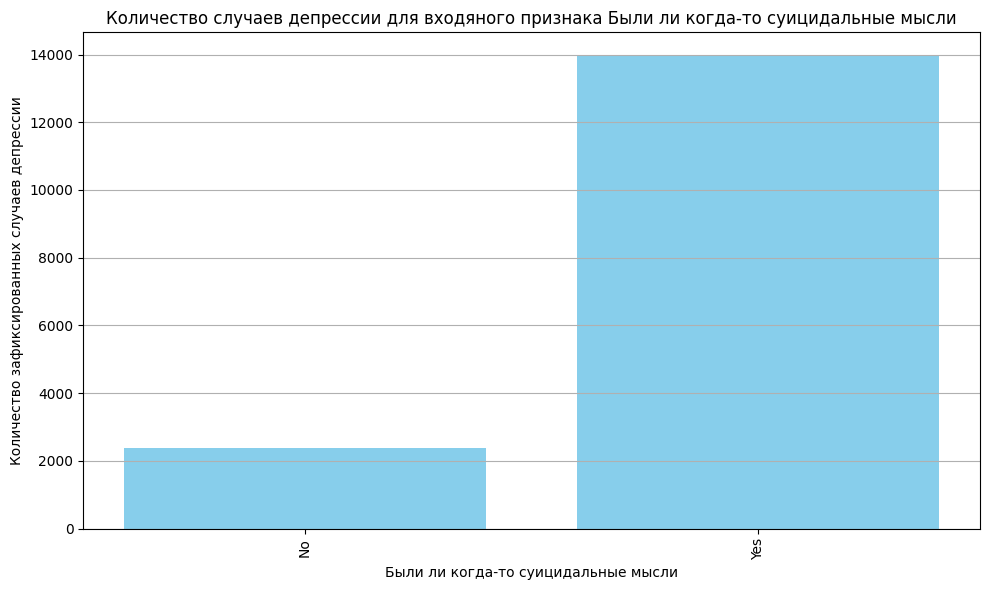

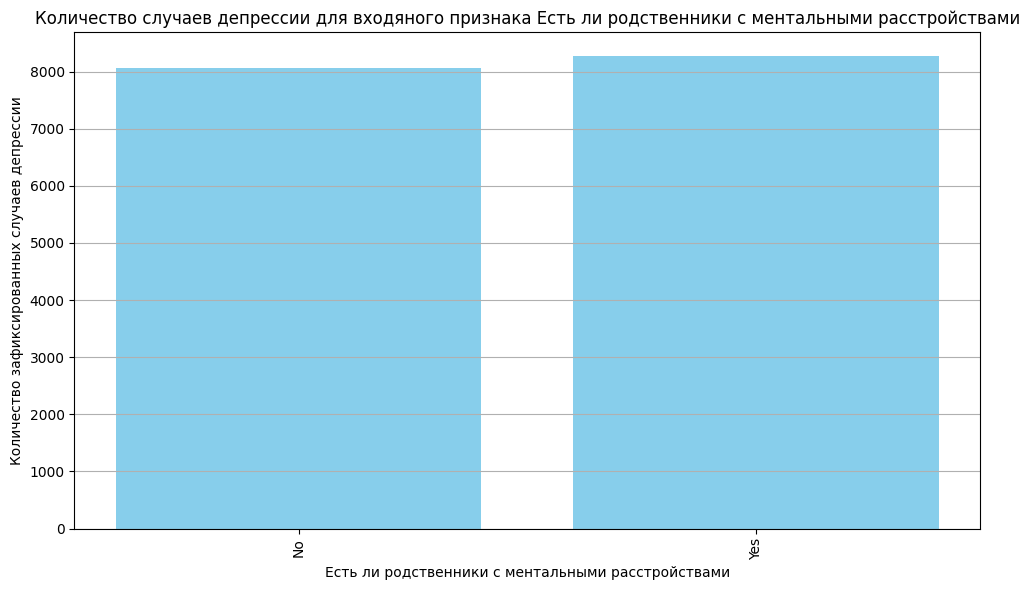

In [12]:
for feature in categorical_features.keys():

    counts = df.groupby(feature)['Depression'].sum().reset_index()

    plt.figure(figsize=(10, 6))
    plt.bar(counts[feature], counts['Depression'], color='skyblue')

    plt.title(
        f'Количество случаев депрессии для входяного признака {categorical_features[feature]}'
    )
    plt.xlabel(categorical_features[feature])
    plt.ylabel('Количество зафиксированных случаев депрессии')

    plt.xticks(rotation=90)

    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

    print(' ')


## Выводы по разделу.
- Данные успешно загружены, пропусков в них нет;
- Учащихся с диагностированной депрессией в данных больше, чем без таковой, это надо будет учесть при разделении данных на выборки для моделей;
- Сильного перекоса в сторону одного из полов учащихся в данных нет;
- Из диаграм, построенных на основе числовых признаков можно сделать предположение, что наибольшее количество случаев депресси у учащихся из нашего датасета зафиксировано среди молодых людей до 30 лет, имеющих высокую учебную нагрузку (с количеством учебных часов 10 и более), средний балл около 8, неработающих, имеющих низкую удовлетворённость своими учебными успехами и высокий финансовый стресс.
- Из диаграм, построенных на основе категориальных признаков можно сделать предположение, что в нашем датасете более подвержены депрессии представители мужского пола (впрочем, объяснение тут может быть простое: они в большей степени представлены в данных), учащиеся заключительного года средней школы, спящие менее 5 часов в сутки, имеющие нездоровые пищевые привычки и наличие суицидальных мыслей в прошлом. По количеству депрессивных учащихся также лидируют некоторые из представленных городов, но это объясняется наибольшим количеством записей по ним в данных.
- Признаки, связанные с работой для подавляющего большинства учащихся в датасете неактуальны, т. к. они (учащиеся) не работают. Пока не будем удалять эти признаки, посмотрим их корреляция с целевым признаком в следующем разделе.

# Корреляции.

 С помощью библиотеки phik посмотрим корреляции признаков.

In [13]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']


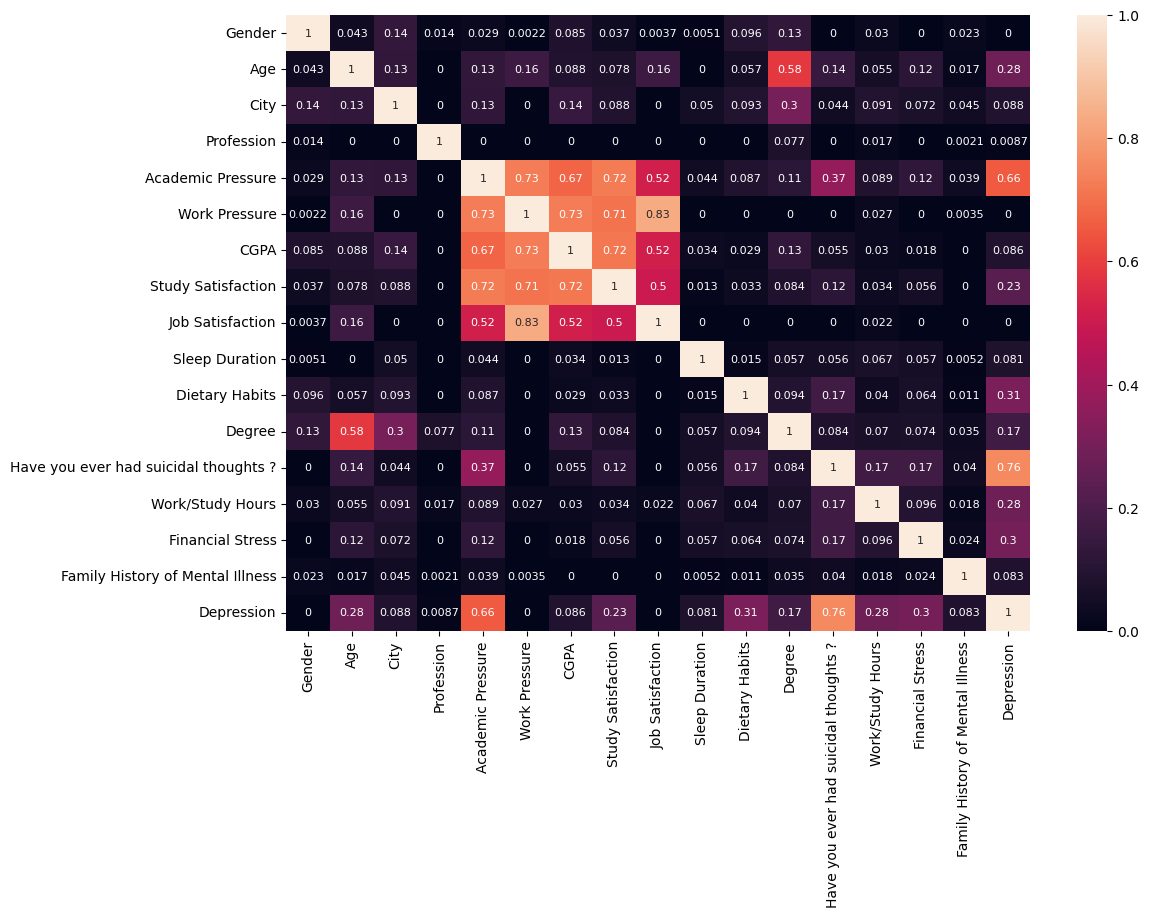

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_overview, annot=True, annot_kws={'fontsize': 8})
plt.show()

Признаки Gender, Work Pressurem Job Satisfaction, Profession не оказывают влияние на целевой признак, поэтому удаляем их как ненужные.

In [15]:
df = df.drop(['Gender', 'Work Pressure', 'Job Satisfaction', 'Profession'], axis=1)

## Выводы по разделу.        

Как и предполагалось выше, признаки, связанные с работой, не оказывают в рамках нашего датасета никакого влияния на наличие или отсутствие у учащихся депрессии. Также бессмысленным с этой точки зрения оказалася признак пола. Мы удалили все эти признаки, т.к. для моделей, которые мы будем строить в следующем пункте они никакой ценности не имеют.

# Машинное обучение.

Выполним отделение входные признаков от целевого.

In [16]:
y = df['Depression']
X = df.drop('Depression', axis=1)

Разбиваем данные на тренировочную и тесовую выборки.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNDM_STATE, stratify=y
)

Создаём списки актуальных числовых и  категориальных признаков.

In [18]:
numerical_features = [
    'Age',
    'Academic Pressure',
    'CGPA',
    'Study Satisfaction',
    'Work/Study Hours',
    'Financial Stress',
]

categorical_features = [
    'City',
    'Sleep Duration',
    'Dietary Habits',
    'Degree',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness',
]

Дальнейшие наши шаги для для определения бустинговой модели, дающей лучшие результаты на данном датасете:
- Стандартизация чисовых признаков и кодирование категориальных;
- Обучение выбранных в начале проекта моделей и оценка достигаемого ими значения метрики F1;
- Построение матрицы ошибок для каждой из моделей;
- Выбор модели с самым высоким значением метрики;
- Подбор для неё наилучших значений гиперпараметров с помощью библиотеки Optuna, вывод значения метрики с этими гиперпараметрами.

XGBoost F1 Score: 0.8611
[LightGBM] [Info] Number of positive: 13068, number of negative: 9252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585484 -> initscore=0.345327
[LightGBM] [Info] Start training from score 0.345327
LightGBM F1 Score: 0.8663
CatBoost F1 Score: 0.8687


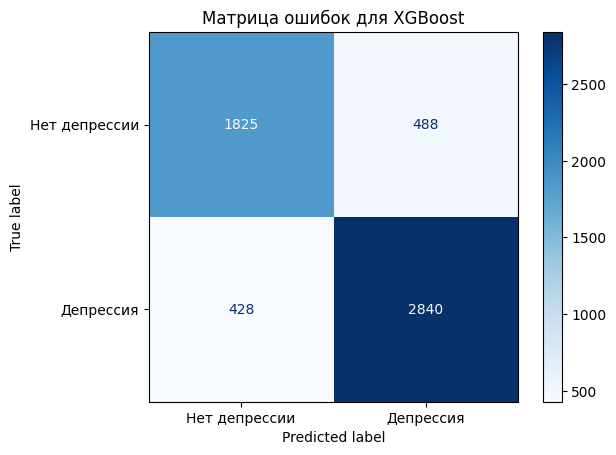

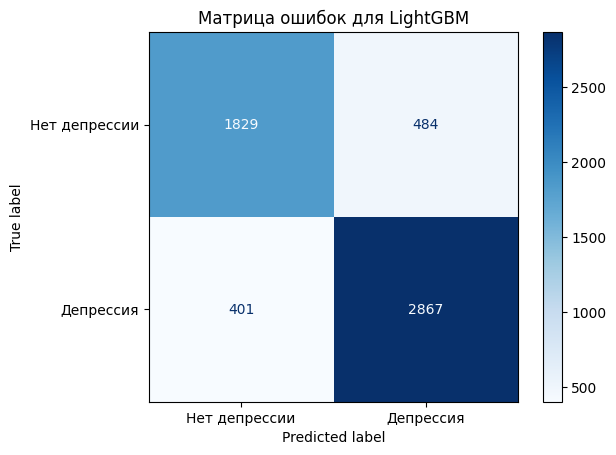

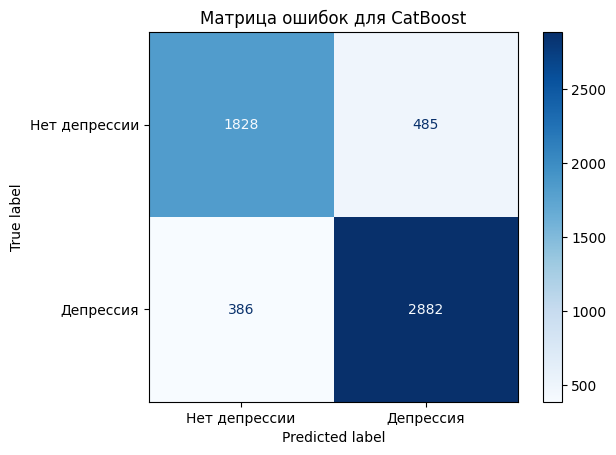

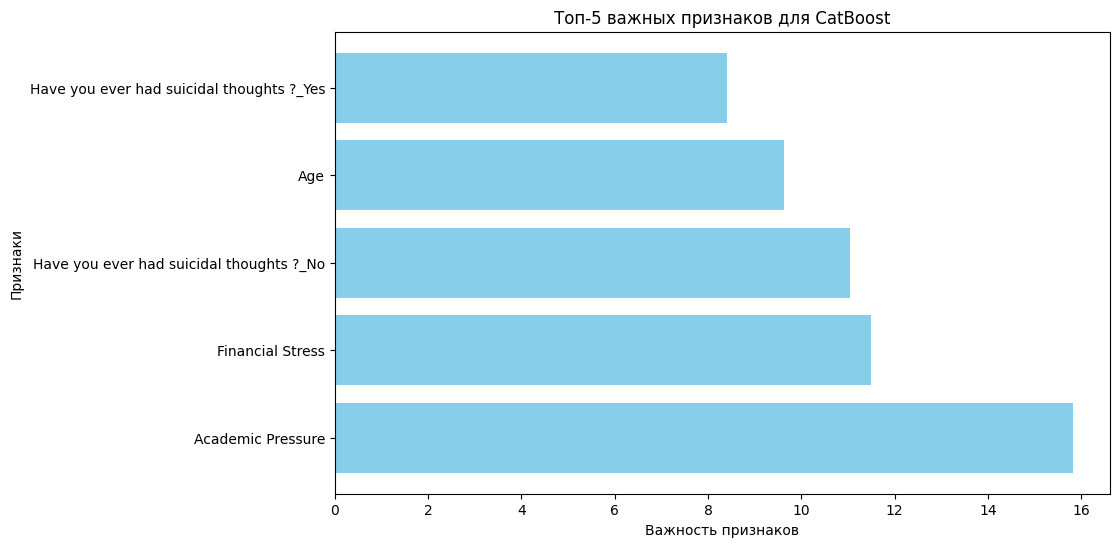

[I 2025-01-26 17:02:08,387] Trial 100 finished with value: 0.8706235912847482 and parameters: {'depth': 5, 'learning_rate': 0.056387259113968316, 'iterations': 147}. Best is trial 20 with value: 0.87261242292074.
[I 2025-01-26 17:02:11,139] Trial 101 finished with value: 0.8721578075591027 and parameters: {'depth': 5, 'learning_rate': 0.04796635566923886, 'iterations': 277}. Best is trial 20 with value: 0.87261242292074.
[I 2025-01-26 17:02:15,057] Trial 102 finished with value: 0.8710212701764971 and parameters: {'depth': 5, 'learning_rate': 0.041953101707156354, 'iterations': 277}. Best is trial 20 with value: 0.87261242292074.
[I 2025-01-26 17:02:17,306] Trial 103 finished with value: 0.8708220415537488 and parameters: {'depth': 6, 'learning_rate': 0.03585500674121188, 'iterations': 267}. Best is trial 20 with value: 0.87261242292074.
[I 2025-01-26 17:02:19,106] Trial 104 finished with value: 0.8708220415537488 and parameters: {'depth': 4, 'learning_rate': 0.05007721441240773, 'iter

Наилучшие гиперпараметры: {'depth': 7, 'learning_rate': 0.06172417923802237, 'iterations': 107}
Значение метрики F1 с оптимизированными гиперпараметрами: 0.8728


In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

# Определение моделей в пайплайне
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=RNDM_STATE),
    'LightGBM': LGBMClassifier(random_state=RNDM_STATE),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=RNDM_STATE),
}

# Словарь для хранения метрик F1 и предсказаний
f1_scores = {}
predictions = {}

# Обучение моделей и оценка метрики F1
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Обучение модели
    pipeline.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = pipeline.predict(X_test)

    # Вычисление метрики F1
    f1 = f1_score(y_test, y_pred)

    # Сохранение метрик и предсказаний
    f1_scores[model_name] = f1
    predictions[model_name] = y_pred

    print(f'{model_name} F1 Score: {f1:.4f}')

    # Сохранение модели в файл с помощью joblib
    joblib.dump(pipeline, f'{model_name}.joblib')

# Построение матрицы ошибок для каждой модели
for model_name in models.keys():
    cm = confusion_matrix(y_test, predictions[model_name])

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=['Нет депрессии', 'Депрессия']
    )

    disp.plot(cmap=plt.cm.Blues)

    plt.title(f'Матрица ошибок для {model_name}')
    plt.show()
    print(' ')

# Определение лучшей модели по метрике F1 Score и загрузка её из файла
best_model_name = max(f1_scores.keys(), key=lambda k: f1_scores[k])
best_model_pipeline = joblib.load(f'{best_model_name}.joblib')

# Получение обученной модели из пайплайна
best_model = best_model_pipeline.named_steps['classifier']

# Отображение важности признаков для лучшей модели
if best_model_name in ['XGBoost', 'LightGBM']:
    feature_importances = best_model.feature_importances_

elif best_model_name == 'CatBoost':
    feature_importances = best_model.get_feature_importance()

# Получение имен признаков после обработки (числовые + категориальные)
feature_names = numerical_features + list(
    preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
)

# Создание таблицы со значением важности признаков

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка по важности и выбор топ-5 признаков
top_5_features = importance_df.sort_values(by='Importance', ascending=False).head(5)

# Визуализация важности топ-5 признаков
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='skyblue')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title(f'Топ-5 важных признаков для {best_model_name}')
plt.show()

def objective(trial):
    if best_model_name == 'XGBoost':
        param = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        }
        model = XGBClassifier(**param, random_state=RNDM_STATE)

    elif best_model_name == 'LightGBM':
        param = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        }
        model = LGBMClassifier(**param, random_state=RNDM_STATE)

    elif best_model_name == 'CatBoost':
        param = {
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'iterations': trial.suggest_int('iterations', 50, 300),
        }
        model = CatBoostClassifier(**param, verbose=0)
        model.set_params(random_seed=RNDM_STATE)

    pipeline_with_optuna = Pipeline(
        steps=[('preprocessor', preprocessor), ('classifier', model)]
    )

    # Обучение модели с текущими гиперпараметрами и оценка метрики F1
    pipeline_with_optuna.fit(X_train, y_train)

    y_pred_optuna = pipeline_with_optuna.predict(X_test)

    return f1_score(y_test, y_pred_optuna)

# Загрузка или создание исследования Optuna
sampler = optuna.samplers.TPESampler(seed=RNDM_STATE)
study_file_path = 'optuna_study.pkl'

try:
    study = joblib.load(study_file_path)  # Попытка загрузить существующее исследование
except FileNotFoundError:
    study = optuna.create_study(
        direction='maximize', sampler=sampler
    )  # Создание нового исследования

# Запуск оптимизации гиперпараметров с помощью Optuna
study.optimize(objective, n_trials=50)

# Сохранение состояния исследования в файл после оптимизации
joblib.dump(study, study_file_path)

print('Наилучшие гиперпараметры:', study.best_params)
best_f1_score = study.best_value

print(f'Значение метрики F1 с оптимизированными гиперпараметрами: {best_f1_score:.4f}')

XGBoost F1 Score: 0.8611
[LightGBM] [Info] Number of positive: 13068, number of negative: 9252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585484 -> initscore=0.345327
[LightGBM] [Info] Start training from score 0.345327
LightGBM F1 Score: 0.8663
CatBoost F1 Score: 0.8687


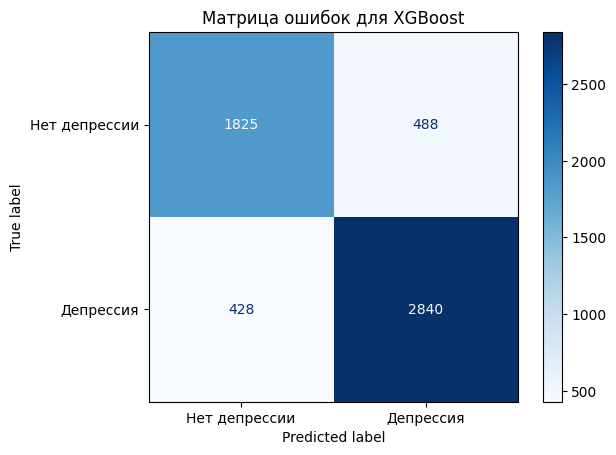

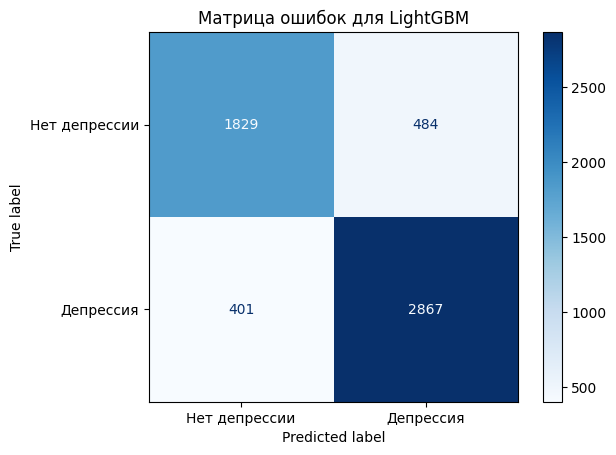

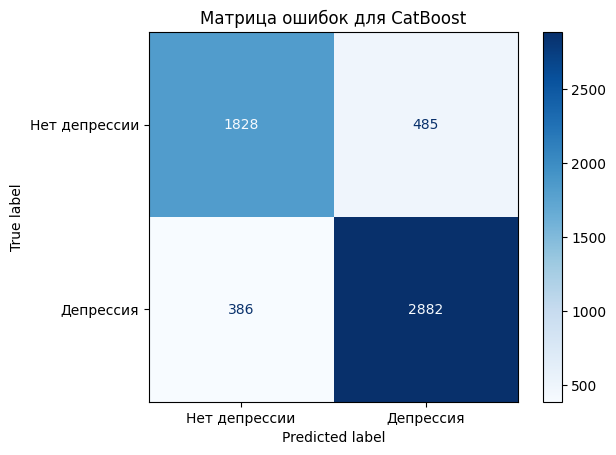

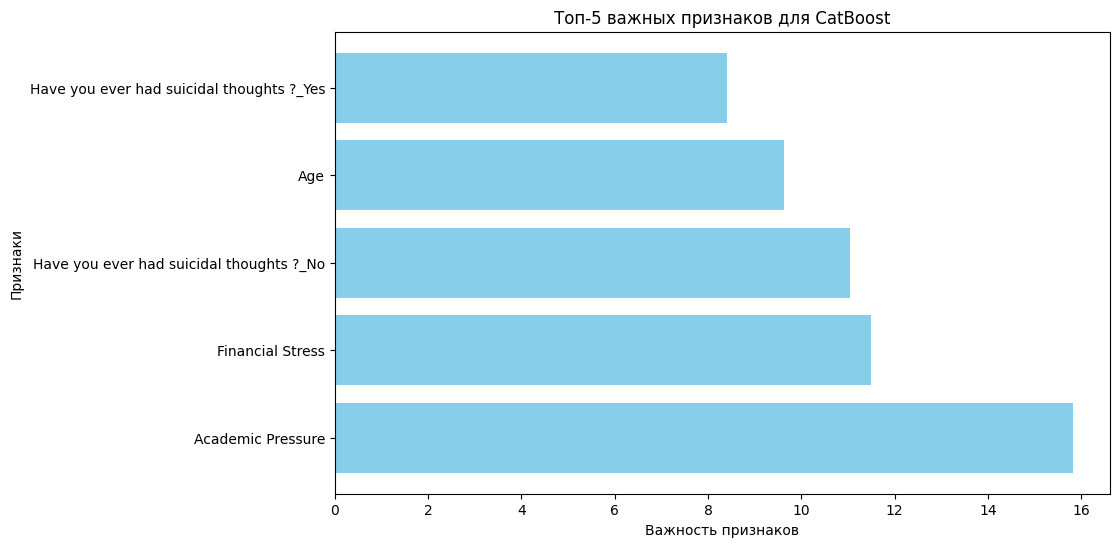

0:	learn: 0.6629241	total: 6.84ms	remaining: 1.92s
1:	learn: 0.6343430	total: 15.2ms	remaining: 2.13s
2:	learn: 0.6099162	total: 25.3ms	remaining: 2.35s
3:	learn: 0.5864085	total: 31.3ms	remaining: 2.17s
4:	learn: 0.5668260	total: 42.2ms	remaining: 2.34s
5:	learn: 0.5482095	total: 51.8ms	remaining: 2.38s
6:	learn: 0.5319801	total: 63.6ms	remaining: 2.5s
7:	learn: 0.5184328	total: 70.5ms	remaining: 2.41s
8:	learn: 0.5055024	total: 75.9ms	remaining: 2.3s
9:	learn: 0.4946659	total: 81.5ms	remaining: 2.22s
10:	learn: 0.4845967	total: 87.6ms	remaining: 2.16s
11:	learn: 0.4756418	total: 93.7ms	remaining: 2.11s
12:	learn: 0.4673379	total: 100ms	remaining: 2.08s
13:	learn: 0.4594079	total: 107ms	remaining: 2.04s
14:	learn: 0.4527172	total: 113ms	remaining: 2s
15:	learn: 0.4464063	total: 118ms	remaining: 1.97s
16:	learn: 0.4406704	total: 124ms	remaining: 1.93s
17:	learn: 0.4352112	total: 130ms	remaining: 1.9s
18:	learn: 0.4306894	total: 136ms	remaining: 1.88s
19:	learn: 0.4266614	total: 141ms	r

[I 2025-01-26 17:03:58,104] Trial 150 finished with value: 0.871254329167294 and parameters: {'max_depth': 4, 'learning_rate': 0.04708343605862616, 'n_estimators': 203, 'num_leaves': 67, 'depth': 4, 'iterations': 282}. Best is trial 120 with value: 0.87279843444227.


0:	learn: 0.6495037	total: 6.31ms	remaining: 1.67s
1:	learn: 0.6090963	total: 19.1ms	remaining: 2.52s
2:	learn: 0.5766962	total: 37.2ms	remaining: 3.26s
3:	learn: 0.5479264	total: 45.7ms	remaining: 3s
4:	learn: 0.5235601	total: 52.1ms	remaining: 2.72s
5:	learn: 0.5036219	total: 58.6ms	remaining: 2.54s
6:	learn: 0.4858372	total: 64.7ms	remaining: 2.39s
7:	learn: 0.4714908	total: 71.3ms	remaining: 2.3s
8:	learn: 0.4580440	total: 77.7ms	remaining: 2.22s
9:	learn: 0.4472568	total: 84.2ms	remaining: 2.15s
10:	learn: 0.4383721	total: 90.9ms	remaining: 2.11s
11:	learn: 0.4305532	total: 97.8ms	remaining: 2.07s
12:	learn: 0.4236404	total: 104ms	remaining: 2.03s
13:	learn: 0.4169217	total: 111ms	remaining: 2s
14:	learn: 0.4112105	total: 118ms	remaining: 1.97s
15:	learn: 0.4062368	total: 124ms	remaining: 1.94s
16:	learn: 0.4014578	total: 131ms	remaining: 1.92s
17:	learn: 0.3977124	total: 137ms	remaining: 1.89s
18:	learn: 0.3942053	total: 143ms	remaining: 1.86s
19:	learn: 0.3909416	total: 153ms	re

[I 2025-01-26 17:04:00,297] Trial 151 finished with value: 0.8706272617611581 and parameters: {'max_depth': 7, 'learning_rate': 0.06523388865127798, 'n_estimators': 81, 'num_leaves': 25, 'depth': 5, 'iterations': 266}. Best is trial 120 with value: 0.87279843444227.


253:	learn: 0.3241714	total: 1.84s	remaining: 86.8ms
254:	learn: 0.3240769	total: 1.84s	remaining: 79.5ms
255:	learn: 0.3239234	total: 1.85s	remaining: 72.3ms
256:	learn: 0.3238236	total: 1.86s	remaining: 65ms
257:	learn: 0.3236871	total: 1.86s	remaining: 57.8ms
258:	learn: 0.3236807	total: 1.87s	remaining: 50.6ms
259:	learn: 0.3235786	total: 1.88s	remaining: 43.3ms
260:	learn: 0.3234691	total: 1.88s	remaining: 36.1ms
261:	learn: 0.3233722	total: 1.89s	remaining: 28.9ms
262:	learn: 0.3233020	total: 1.9s	remaining: 21.7ms
263:	learn: 0.3231622	total: 1.9s	remaining: 14.4ms
264:	learn: 0.3230108	total: 1.91s	remaining: 7.22ms
265:	learn: 0.3228853	total: 1.92s	remaining: 0us
0:	learn: 0.6517138	total: 17.1ms	remaining: 3.53s
1:	learn: 0.6130092	total: 23.8ms	remaining: 2.46s
2:	learn: 0.5816959	total: 30ms	remaining: 2.05s
3:	learn: 0.5536294	total: 36.4ms	remaining: 1.86s
4:	learn: 0.5299783	total: 43.7ms	remaining: 1.77s
5:	learn: 0.5102456	total: 50.5ms	remaining: 1.7s
6:	learn: 0.492

[I 2025-01-26 17:04:02,482] Trial 152 finished with value: 0.8709823449524673 and parameters: {'max_depth': 7, 'learning_rate': 0.06177029520969351, 'n_estimators': 231, 'num_leaves': 33, 'depth': 5, 'iterations': 208}. Best is trial 120 with value: 0.87279843444227.


0:	learn: 0.6549945	total: 6.47ms	remaining: 1.77s
1:	learn: 0.6189167	total: 12.6ms	remaining: 1.72s
2:	learn: 0.5875742	total: 19.4ms	remaining: 1.76s
3:	learn: 0.5625271	total: 26.3ms	remaining: 1.78s
4:	learn: 0.5404394	total: 32.7ms	remaining: 1.77s
5:	learn: 0.5204837	total: 39.6ms	remaining: 1.77s
6:	learn: 0.5030134	total: 45.6ms	remaining: 1.75s
7:	learn: 0.4881749	total: 52.3ms	remaining: 1.75s
8:	learn: 0.4748740	total: 58.7ms	remaining: 1.74s
9:	learn: 0.4633095	total: 65.5ms	remaining: 1.74s
10:	learn: 0.4532606	total: 72.7ms	remaining: 1.75s
11:	learn: 0.4441736	total: 79ms	remaining: 1.73s
12:	learn: 0.4355866	total: 85.4ms	remaining: 1.72s
13:	learn: 0.4281707	total: 91.5ms	remaining: 1.71s
14:	learn: 0.4222854	total: 97.4ms	remaining: 1.69s
15:	learn: 0.4170468	total: 104ms	remaining: 1.68s
16:	learn: 0.4117778	total: 110ms	remaining: 1.67s
17:	learn: 0.4071602	total: 117ms	remaining: 1.67s
18:	learn: 0.4031652	total: 123ms	remaining: 1.66s
19:	learn: 0.3995297	total: 

[I 2025-01-26 17:04:05,555] Trial 153 finished with value: 0.8732266827648657 and parameters: {'max_depth': 6, 'learning_rate': 0.0566421070707054, 'n_estimators': 211, 'num_leaves': 28, 'depth': 5, 'iterations': 275}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6551650	total: 9.13ms	remaining: 2.49s
1:	learn: 0.6192098	total: 19.6ms	remaining: 2.66s
2:	learn: 0.5896724	total: 28.1ms	remaining: 2.54s
3:	learn: 0.5628444	total: 36.3ms	remaining: 2.45s
4:	learn: 0.5405672	total: 44.7ms	remaining: 2.4s
5:	learn: 0.5207651	total: 53.6ms	remaining: 2.39s
6:	learn: 0.5028547	total: 62.1ms	remaining: 2.37s
7:	learn: 0.4877826	total: 71.3ms	remaining: 2.37s
8:	learn: 0.4759103	total: 79.8ms	remaining: 2.35s
9:	learn: 0.4636885	total: 88.8ms	remaining: 2.35s
10:	learn: 0.4533129	total: 98.6ms	remaining: 2.36s
11:	learn: 0.4451267	total: 108ms	remaining: 2.37s
12:	learn: 0.4369714	total: 118ms	remaining: 2.36s
13:	learn: 0.4297863	total: 126ms	remaining: 2.34s
14:	learn: 0.4230274	total: 135ms	remaining: 2.32s
15:	learn: 0.4174472	total: 143ms	remaining: 2.31s
16:	learn: 0.4125027	total: 152ms	remaining: 2.29s
17:	learn: 0.4081409	total: 160ms	remaining: 2.28s
18:	learn: 0.4038337	total: 178ms	remaining: 2.38s
19:	learn: 0.4001945	total: 199

[I 2025-01-26 17:04:10,248] Trial 154 finished with value: 0.8725682400844518 and parameters: {'max_depth': 6, 'learning_rate': 0.05638991159701113, 'n_estimators': 215, 'num_leaves': 48, 'depth': 5, 'iterations': 274}. Best is trial 153 with value: 0.8732266827648657.


255:	learn: 0.3275544	total: 4.07s	remaining: 286ms
256:	learn: 0.3274463	total: 4.08s	remaining: 270ms
257:	learn: 0.3273799	total: 4.08s	remaining: 253ms
258:	learn: 0.3272734	total: 4.09s	remaining: 237ms
259:	learn: 0.3271628	total: 4.1s	remaining: 221ms
260:	learn: 0.3270873	total: 4.11s	remaining: 205ms
261:	learn: 0.3270006	total: 4.11s	remaining: 188ms
262:	learn: 0.3269071	total: 4.12s	remaining: 172ms
263:	learn: 0.3267808	total: 4.13s	remaining: 156ms
264:	learn: 0.3266642	total: 4.13s	remaining: 140ms
265:	learn: 0.3265833	total: 4.14s	remaining: 124ms
266:	learn: 0.3264574	total: 4.15s	remaining: 109ms
267:	learn: 0.3264362	total: 4.15s	remaining: 93ms
268:	learn: 0.3263311	total: 4.16s	remaining: 77.3ms
269:	learn: 0.3262431	total: 4.17s	remaining: 61.8ms
270:	learn: 0.3261773	total: 4.18s	remaining: 46.3ms
271:	learn: 0.3260729	total: 4.19s	remaining: 30.8ms
272:	learn: 0.3260509	total: 4.2s	remaining: 15.4ms
273:	learn: 0.3259577	total: 4.2s	remaining: 0us
0:	learn: 0.6

[I 2025-01-26 17:04:12,550] Trial 155 finished with value: 0.871376811594203 and parameters: {'max_depth': 6, 'learning_rate': 0.056866209831234645, 'n_estimators': 195, 'num_leaves': 27, 'depth': 5, 'iterations': 276}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6608086	total: 5.55ms	remaining: 1.61s
1:	learn: 0.6304803	total: 14.5ms	remaining: 2.09s
2:	learn: 0.6030624	total: 20.4ms	remaining: 1.96s
3:	learn: 0.5790996	total: 26.1ms	remaining: 1.88s
4:	learn: 0.5581608	total: 32.4ms	remaining: 1.85s
5:	learn: 0.5403679	total: 38.2ms	remaining: 1.81s
6:	learn: 0.5239152	total: 44.2ms	remaining: 1.79s
7:	learn: 0.5094786	total: 49.8ms	remaining: 1.76s
8:	learn: 0.4970511	total: 55.5ms	remaining: 1.74s
9:	learn: 0.4855921	total: 61.6ms	remaining: 1.73s
10:	learn: 0.4755682	total: 68.1ms	remaining: 1.73s
11:	learn: 0.4673308	total: 73.7ms	remaining: 1.71s
12:	learn: 0.4600835	total: 80ms	remaining: 1.71s
13:	learn: 0.4524434	total: 86.4ms	remaining: 1.71s
14:	learn: 0.4455270	total: 92.6ms	remaining: 1.7s
15:	learn: 0.4403300	total: 98.5ms	remaining: 1.69s
16:	learn: 0.4345820	total: 105ms	remaining: 1.69s
17:	learn: 0.4299344	total: 110ms	remaining: 1.67s
18:	learn: 0.4251290	total: 116ms	remaining: 1.66s
19:	learn: 0.4209605	total: 

[I 2025-01-26 17:04:14,710] Trial 156 finished with value: 0.8708753955100197 and parameters: {'max_depth': 5, 'learning_rate': 0.050512908630144, 'n_estimators': 218, 'num_leaves': 50, 'depth': 4, 'iterations': 291}. Best is trial 153 with value: 0.8732266827648657.


280:	learn: 0.3357952	total: 1.82s	remaining: 64.7ms
281:	learn: 0.3357370	total: 1.82s	remaining: 58.3ms
282:	learn: 0.3357307	total: 1.83s	remaining: 51.8ms
283:	learn: 0.3356633	total: 1.84s	remaining: 45.3ms
284:	learn: 0.3355976	total: 1.84s	remaining: 38.8ms
285:	learn: 0.3355917	total: 1.85s	remaining: 32.3ms
286:	learn: 0.3355381	total: 1.86s	remaining: 25.9ms
287:	learn: 0.3354718	total: 1.86s	remaining: 19.4ms
288:	learn: 0.3354070	total: 1.87s	remaining: 12.9ms
289:	learn: 0.3353278	total: 1.88s	remaining: 6.47ms
290:	learn: 0.3352534	total: 1.88s	remaining: 0us
0:	learn: 0.6572018	total: 6.17ms	remaining: 1.68s
1:	learn: 0.6229345	total: 12.8ms	remaining: 1.73s
2:	learn: 0.5945058	total: 20.7ms	remaining: 1.86s
3:	learn: 0.5683874	total: 29.9ms	remaining: 2.01s
4:	learn: 0.5465027	total: 37.6ms	remaining: 2.01s
5:	learn: 0.5268514	total: 46.1ms	remaining: 2.05s
6:	learn: 0.5101875	total: 52.5ms	remaining: 1.99s
7:	learn: 0.4954207	total: 59ms	remaining: 1.95s
8:	learn: 0.48

[I 2025-01-26 17:04:16,955] Trial 157 finished with value: 0.8726066636514398 and parameters: {'max_depth': 6, 'learning_rate': 0.05321576398018849, 'n_estimators': 247, 'num_leaves': 47, 'depth': 5, 'iterations': 273}. Best is trial 153 with value: 0.8732266827648657.


254:	learn: 0.3291332	total: 1.83s	remaining: 129ms
255:	learn: 0.3290349	total: 1.84s	remaining: 122ms
256:	learn: 0.3289706	total: 1.84s	remaining: 115ms
257:	learn: 0.3288594	total: 1.85s	remaining: 108ms
258:	learn: 0.3287707	total: 1.86s	remaining: 100ms
259:	learn: 0.3287643	total: 1.86s	remaining: 93.1ms
260:	learn: 0.3286690	total: 1.87s	remaining: 85.9ms
261:	learn: 0.3286346	total: 1.88s	remaining: 78.7ms
262:	learn: 0.3285481	total: 1.88s	remaining: 71.6ms
263:	learn: 0.3284774	total: 1.89s	remaining: 64.4ms
264:	learn: 0.3283741	total: 1.9s	remaining: 57.2ms
265:	learn: 0.3282943	total: 1.9s	remaining: 50.1ms
266:	learn: 0.3282079	total: 1.91s	remaining: 42.9ms
267:	learn: 0.3281496	total: 1.92s	remaining: 35.7ms
268:	learn: 0.3280713	total: 1.92s	remaining: 28.6ms
269:	learn: 0.3280098	total: 1.93s	remaining: 21.4ms
270:	learn: 0.3279766	total: 1.93s	remaining: 14.3ms
271:	learn: 0.3278671	total: 1.94s	remaining: 7.15ms
272:	learn: 0.3277521	total: 1.95s	remaining: 0us
0:	

[I 2025-01-26 17:04:19,259] Trial 158 finished with value: 0.8718335343787696 and parameters: {'max_depth': 6, 'learning_rate': 0.056218422730978254, 'n_estimators': 244, 'num_leaves': 37, 'depth': 5, 'iterations': 271}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6576091	total: 6.39ms	remaining: 1.82s
1:	learn: 0.6236809	total: 13.3ms	remaining: 1.88s
2:	learn: 0.5941850	total: 19.7ms	remaining: 1.86s
3:	learn: 0.5702210	total: 26.4ms	remaining: 1.86s
4:	learn: 0.5476447	total: 33ms	remaining: 1.85s
5:	learn: 0.5277159	total: 39.6ms	remaining: 1.85s
6:	learn: 0.5102588	total: 46.4ms	remaining: 1.85s
7:	learn: 0.4950509	total: 53.3ms	remaining: 1.85s
8:	learn: 0.4819565	total: 59.8ms	remaining: 1.84s
9:	learn: 0.4703267	total: 66.4ms	remaining: 1.83s
10:	learn: 0.4605672	total: 72.6ms	remaining: 1.81s
11:	learn: 0.4515384	total: 79.4ms	remaining: 1.81s
12:	learn: 0.4434308	total: 86.2ms	remaining: 1.81s
13:	learn: 0.4360366	total: 92.8ms	remaining: 1.8s
14:	learn: 0.4290948	total: 99.1ms	remaining: 1.79s
15:	learn: 0.4231910	total: 106ms	remaining: 1.78s
16:	learn: 0.4179006	total: 112ms	remaining: 1.78s
17:	learn: 0.4131022	total: 119ms	remaining: 1.77s
18:	learn: 0.4088089	total: 125ms	remaining: 1.76s
19:	learn: 0.4049760	total: 1

[I 2025-01-26 17:04:23,577] Trial 159 finished with value: 0.8715706964124209 and parameters: {'max_depth': 6, 'learning_rate': 0.052586166785679345, 'n_estimators': 283, 'num_leaves': 59, 'depth': 5, 'iterations': 286}. Best is trial 153 with value: 0.8732266827648657.


285:	learn: 0.3265964	total: 3.9s	remaining: 0us
0:	learn: 0.6705995	total: 19.5ms	remaining: 5.41s
1:	learn: 0.6480163	total: 29.2ms	remaining: 4.03s
2:	learn: 0.6281924	total: 36.4ms	remaining: 3.34s
3:	learn: 0.6090941	total: 44.5ms	remaining: 3.05s
4:	learn: 0.5922952	total: 52.9ms	remaining: 2.89s
5:	learn: 0.5763338	total: 61.9ms	remaining: 2.81s
6:	learn: 0.5616158	total: 71.3ms	remaining: 2.76s
7:	learn: 0.5488780	total: 80ms	remaining: 2.7s
8:	learn: 0.5371043	total: 88.9ms	remaining: 2.66s
9:	learn: 0.5249228	total: 99.9ms	remaining: 2.68s
10:	learn: 0.5139745	total: 110ms	remaining: 2.66s
11:	learn: 0.5039335	total: 118ms	remaining: 2.61s
12:	learn: 0.4958316	total: 126ms	remaining: 2.57s
13:	learn: 0.4872464	total: 135ms	remaining: 2.55s
14:	learn: 0.4792089	total: 152ms	remaining: 2.67s
15:	learn: 0.4721321	total: 168ms	remaining: 2.75s
16:	learn: 0.4656994	total: 185ms	remaining: 2.84s
17:	learn: 0.4593143	total: 201ms	remaining: 2.91s
18:	learn: 0.4539856	total: 231ms	re

[I 2025-01-26 17:04:26,384] Trial 160 finished with value: 0.8708997893469757 and parameters: {'max_depth': 6, 'learning_rate': 0.032870149676407834, 'n_estimators': 212, 'num_leaves': 45, 'depth': 5, 'iterations': 278}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6509632	total: 6.4ms	remaining: 1.75s
1:	learn: 0.6117040	total: 13.2ms	remaining: 1.79s
2:	learn: 0.5800244	total: 19.9ms	remaining: 1.8s
3:	learn: 0.5517147	total: 26.8ms	remaining: 1.81s
4:	learn: 0.5274807	total: 33ms	remaining: 1.77s
5:	learn: 0.5071101	total: 39.5ms	remaining: 1.76s
6:	learn: 0.4903406	total: 46.1ms	remaining: 1.76s
7:	learn: 0.4759569	total: 52.7ms	remaining: 1.75s
8:	learn: 0.4629223	total: 60.3ms	remaining: 1.78s
9:	learn: 0.4508818	total: 66.5ms	remaining: 1.75s
10:	learn: 0.4406949	total: 72.7ms	remaining: 1.74s
11:	learn: 0.4322639	total: 79.2ms	remaining: 1.73s
12:	learn: 0.4253626	total: 85.7ms	remaining: 1.72s
13:	learn: 0.4186094	total: 92.3ms	remaining: 1.71s
14:	learn: 0.4125304	total: 98.7ms	remaining: 1.7s
15:	learn: 0.4081367	total: 107ms	remaining: 1.73s
16:	learn: 0.4034875	total: 113ms	remaining: 1.71s
17:	learn: 0.3992186	total: 120ms	remaining: 1.71s
18:	learn: 0.3958209	total: 127ms	remaining: 1.7s
19:	learn: 0.3926856	total: 133m

[I 2025-01-26 17:04:28,656] Trial 161 finished with value: 0.8726834413138466 and parameters: {'max_depth': 5, 'learning_rate': 0.06292416819720245, 'n_estimators': 228, 'num_leaves': 48, 'depth': 5, 'iterations': 274}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6519000	total: 6.25ms	remaining: 1.69s
1:	learn: 0.6133560	total: 13.2ms	remaining: 1.77s
2:	learn: 0.5821237	total: 20ms	remaining: 1.79s
3:	learn: 0.5541235	total: 26.3ms	remaining: 1.75s
4:	learn: 0.5305111	total: 34.3ms	remaining: 1.82s
5:	learn: 0.5097101	total: 40.4ms	remaining: 1.78s
6:	learn: 0.4930548	total: 47.3ms	remaining: 1.78s
7:	learn: 0.4783279	total: 56.7ms	remaining: 1.86s
8:	learn: 0.4655117	total: 63.3ms	remaining: 1.84s
9:	learn: 0.4533496	total: 71.1ms	remaining: 1.85s
10:	learn: 0.4438024	total: 81.9ms	remaining: 1.94s
11:	learn: 0.4349202	total: 90.1ms	remaining: 1.95s
12:	learn: 0.4287299	total: 97.8ms	remaining: 1.94s
13:	learn: 0.4216163	total: 104ms	remaining: 1.91s
14:	learn: 0.4157650	total: 110ms	remaining: 1.88s
15:	learn: 0.4101740	total: 117ms	remaining: 1.86s
16:	learn: 0.4053511	total: 123ms	remaining: 1.84s
17:	learn: 0.4010559	total: 130ms	remaining: 1.83s
18:	learn: 0.3973166	total: 137ms	remaining: 1.82s
19:	learn: 0.3943329	total: 14

[I 2025-01-26 17:04:30,873] Trial 162 finished with value: 0.8729847822811512 and parameters: {'max_depth': 5, 'learning_rate': 0.06146458543298075, 'n_estimators': 245, 'num_leaves': 49, 'depth': 5, 'iterations': 271}. Best is trial 153 with value: 0.8732266827648657.


256:	learn: 0.3260593	total: 1.84s	remaining: 100ms
257:	learn: 0.3259240	total: 1.85s	remaining: 93.4ms
258:	learn: 0.3258237	total: 1.86s	remaining: 86.2ms
259:	learn: 0.3257114	total: 1.87s	remaining: 79ms
260:	learn: 0.3256246	total: 1.87s	remaining: 71.8ms
261:	learn: 0.3255336	total: 1.88s	remaining: 64.6ms
262:	learn: 0.3254699	total: 1.89s	remaining: 57.4ms
263:	learn: 0.3253505	total: 1.89s	remaining: 50.2ms
264:	learn: 0.3252856	total: 1.9s	remaining: 43ms
265:	learn: 0.3252779	total: 1.9s	remaining: 35.8ms
266:	learn: 0.3251793	total: 1.91s	remaining: 28.6ms
267:	learn: 0.3250426	total: 1.92s	remaining: 21.5ms
268:	learn: 0.3249434	total: 1.92s	remaining: 14.3ms
269:	learn: 0.3248485	total: 1.93s	remaining: 7.16ms
270:	learn: 0.3248404	total: 1.94s	remaining: 0us
0:	learn: 0.6500858	total: 6.23ms	remaining: 1.75s
1:	learn: 0.6101128	total: 12.4ms	remaining: 1.73s
2:	learn: 0.5780066	total: 18.6ms	remaining: 1.73s
3:	learn: 0.5494106	total: 25.2ms	remaining: 1.75s
4:	learn: 0

[I 2025-01-26 17:04:33,168] Trial 163 finished with value: 0.8705775627456911 and parameters: {'max_depth': 5, 'learning_rate': 0.06432827236097359, 'n_estimators': 227, 'num_leaves': 49, 'depth': 5, 'iterations': 282}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6520491	total: 7.64ms	remaining: 2.25s
1:	learn: 0.6136082	total: 13.6ms	remaining: 2s
2:	learn: 0.5824477	total: 20.1ms	remaining: 1.97s
3:	learn: 0.5543258	total: 26.7ms	remaining: 1.95s
4:	learn: 0.5308119	total: 33.6ms	remaining: 1.96s
5:	learn: 0.5100265	total: 39.7ms	remaining: 1.92s
6:	learn: 0.4932421	total: 46.3ms	remaining: 1.91s
7:	learn: 0.4782405	total: 53.3ms	remaining: 1.92s
8:	learn: 0.4660349	total: 60.1ms	remaining: 1.92s
9:	learn: 0.4548225	total: 67ms	remaining: 1.92s
10:	learn: 0.4450989	total: 73.6ms	remaining: 1.91s
11:	learn: 0.4379342	total: 80.1ms	remaining: 1.89s
12:	learn: 0.4298000	total: 90.9ms	remaining: 1.98s
13:	learn: 0.4237810	total: 97.5ms	remaining: 1.96s
14:	learn: 0.4178274	total: 104ms	remaining: 1.94s
15:	learn: 0.4122246	total: 111ms	remaining: 1.94s
16:	learn: 0.4072147	total: 117ms	remaining: 1.92s
17:	learn: 0.4027932	total: 123ms	remaining: 1.91s
18:	learn: 0.3988210	total: 130ms	remaining: 1.9s
19:	learn: 0.3951434	total: 137ms

[I 2025-01-26 17:04:36,540] Trial 164 finished with value: 0.871376811594203 and parameters: {'max_depth': 5, 'learning_rate': 0.06124597659403085, 'n_estimators': 245, 'num_leaves': 64, 'depth': 5, 'iterations': 296}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6561949	total: 16.9ms	remaining: 4.6s
1:	learn: 0.6210759	total: 43.8ms	remaining: 5.93s
2:	learn: 0.5920942	total: 58.9ms	remaining: 5.3s
3:	learn: 0.5656710	total: 78.9ms	remaining: 5.3s
4:	learn: 0.5430053	total: 97.8ms	remaining: 5.24s
5:	learn: 0.5246296	total: 117ms	remaining: 5.2s
6:	learn: 0.5071120	total: 127ms	remaining: 4.82s
7:	learn: 0.4918788	total: 135ms	remaining: 4.48s
8:	learn: 0.4782346	total: 144ms	remaining: 4.22s
9:	learn: 0.4671411	total: 152ms	remaining: 3.99s
10:	learn: 0.4577402	total: 160ms	remaining: 3.81s
11:	learn: 0.4485924	total: 168ms	remaining: 3.65s
12:	learn: 0.4399200	total: 176ms	remaining: 3.52s
13:	learn: 0.4330725	total: 185ms	remaining: 3.42s
14:	learn: 0.4261807	total: 193ms	remaining: 3.32s
15:	learn: 0.4203541	total: 201ms	remaining: 3.23s
16:	learn: 0.4150141	total: 213ms	remaining: 3.21s
17:	learn: 0.4102089	total: 236ms	remaining: 3.34s
18:	learn: 0.4064050	total: 246ms	remaining: 3.29s
19:	learn: 0.4024797	total: 264ms	remain

[I 2025-01-26 17:04:40,176] Trial 165 finished with value: 0.8691320754716981 and parameters: {'max_depth': 6, 'learning_rate': 0.05479272922351695, 'n_estimators': 233, 'num_leaves': 56, 'depth': 5, 'iterations': 273}. Best is trial 153 with value: 0.8732266827648657.


256:	learn: 0.3279694	total: 3.08s	remaining: 192ms
257:	learn: 0.3278496	total: 3.08s	remaining: 179ms
258:	learn: 0.3277501	total: 3.09s	remaining: 167ms
259:	learn: 0.3276528	total: 3.1s	remaining: 155ms
260:	learn: 0.3275962	total: 3.1s	remaining: 143ms
261:	learn: 0.3275317	total: 3.11s	remaining: 131ms
262:	learn: 0.3274822	total: 3.12s	remaining: 119ms
263:	learn: 0.3273786	total: 3.12s	remaining: 107ms
264:	learn: 0.3273558	total: 3.13s	remaining: 94.5ms
265:	learn: 0.3272530	total: 3.14s	remaining: 82.6ms
266:	learn: 0.3271546	total: 3.15s	remaining: 70.7ms
267:	learn: 0.3270797	total: 3.15s	remaining: 58.9ms
268:	learn: 0.3269816	total: 3.16s	remaining: 47ms
269:	learn: 0.3269017	total: 3.17s	remaining: 35.2ms
270:	learn: 0.3268394	total: 3.17s	remaining: 23.4ms
271:	learn: 0.3267739	total: 3.18s	remaining: 11.7ms
272:	learn: 0.3267654	total: 3.19s	remaining: 0us
0:	learn: 0.6525959	total: 6.31ms	remaining: 1.67s
1:	learn: 0.6146018	total: 15ms	remaining: 1.98s
2:	learn: 0.58

[I 2025-01-26 17:04:42,381] Trial 166 finished with value: 0.8712452830188678 and parameters: {'max_depth': 5, 'learning_rate': 0.060377622198344603, 'n_estimators': 250, 'num_leaves': 38, 'depth': 5, 'iterations': 266}. Best is trial 153 with value: 0.8732266827648657.


253:	learn: 0.3263612	total: 1.85s	remaining: 87.3ms
254:	learn: 0.3262303	total: 1.85s	remaining: 80ms
255:	learn: 0.3261400	total: 1.86s	remaining: 72.7ms
256:	learn: 0.3260578	total: 1.87s	remaining: 65.4ms
257:	learn: 0.3259683	total: 1.87s	remaining: 58.1ms
258:	learn: 0.3258518	total: 1.88s	remaining: 50.8ms
259:	learn: 0.3257459	total: 1.89s	remaining: 43.6ms
260:	learn: 0.3257189	total: 1.89s	remaining: 36.3ms
261:	learn: 0.3256325	total: 1.9s	remaining: 29ms
262:	learn: 0.3255341	total: 1.91s	remaining: 21.8ms
263:	learn: 0.3253806	total: 1.91s	remaining: 14.5ms
264:	learn: 0.3252864	total: 1.92s	remaining: 7.25ms
265:	learn: 0.3252786	total: 1.93s	remaining: 0us
0:	learn: 0.6470980	total: 6.87ms	remaining: 1.88s
1:	learn: 0.6018587	total: 16.1ms	remaining: 2.2s
2:	learn: 0.5657640	total: 25.6ms	remaining: 2.31s
3:	learn: 0.5351659	total: 34ms	remaining: 2.29s
4:	learn: 0.5098212	total: 43.3ms	remaining: 2.33s
5:	learn: 0.4888801	total: 52.4ms	remaining: 2.34s
6:	learn: 0.4710

[I 2025-01-26 17:04:45,276] Trial 167 finished with value: 0.869079939668175 and parameters: {'max_depth': 6, 'learning_rate': 0.06904522172686928, 'n_estimators': 268, 'num_leaves': 24, 'depth': 7, 'iterations': 274}. Best is trial 153 with value: 0.8732266827648657.


261:	learn: 0.2916056	total: 2.47s	remaining: 113ms
262:	learn: 0.2913297	total: 2.48s	remaining: 104ms
263:	learn: 0.2913224	total: 2.49s	remaining: 94.3ms
264:	learn: 0.2912528	total: 2.5s	remaining: 84.8ms
265:	learn: 0.2910203	total: 2.51s	remaining: 75.6ms
266:	learn: 0.2908279	total: 2.54s	remaining: 66.5ms
267:	learn: 0.2905948	total: 2.54s	remaining: 57ms
268:	learn: 0.2904543	total: 2.55s	remaining: 47.5ms
269:	learn: 0.2904474	total: 2.56s	remaining: 37.9ms
270:	learn: 0.2903175	total: 2.57s	remaining: 28.5ms
271:	learn: 0.2901176	total: 2.58s	remaining: 19ms
272:	learn: 0.2899425	total: 2.59s	remaining: 9.48ms
273:	learn: 0.2896602	total: 2.6s	remaining: 0us
0:	learn: 0.6604133	total: 6.29ms	remaining: 1.75s
1:	learn: 0.6288359	total: 12.4ms	remaining: 1.72s
2:	learn: 0.6022678	total: 18.8ms	remaining: 1.73s
3:	learn: 0.5776596	total: 24.7ms	remaining: 1.7s
4:	learn: 0.5561996	total: 30.8ms	remaining: 1.69s
5:	learn: 0.5367845	total: 36.7ms	remaining: 1.67s
6:	learn: 0.52093

[I 2025-01-26 17:04:47,570] Trial 168 finished with value: 0.8713080168776371 and parameters: {'max_depth': 5, 'learning_rate': 0.0482689454308867, 'n_estimators': 202, 'num_leaves': 48, 'depth': 5, 'iterations': 279}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6560909	total: 6.76ms	remaining: 1.81s
1:	learn: 0.6199347	total: 14.1ms	remaining: 1.89s
2:	learn: 0.5893055	total: 21.8ms	remaining: 1.93s
3:	learn: 0.5634302	total: 29ms	remaining: 1.92s
4:	learn: 0.5402312	total: 36.5ms	remaining: 1.93s
5:	learn: 0.5184520	total: 43.8ms	remaining: 1.92s
6:	learn: 0.5003546	total: 51.7ms	remaining: 1.94s
7:	learn: 0.4844407	total: 59.4ms	remaining: 1.94s
8:	learn: 0.4702999	total: 67.1ms	remaining: 1.94s
9:	learn: 0.4583583	total: 74.9ms	remaining: 1.94s
10:	learn: 0.4482665	total: 82.6ms	remaining: 1.94s
11:	learn: 0.4383304	total: 90.3ms	remaining: 1.93s
12:	learn: 0.4297998	total: 98.2ms	remaining: 1.93s
13:	learn: 0.4222409	total: 106ms	remaining: 1.94s
14:	learn: 0.4159463	total: 114ms	remaining: 1.93s
15:	learn: 0.4098491	total: 122ms	remaining: 1.93s
16:	learn: 0.4044606	total: 133ms	remaining: 1.97s
17:	learn: 0.3999444	total: 144ms	remaining: 2.01s
18:	learn: 0.3958721	total: 154ms	remaining: 2.02s
19:	learn: 0.3922329	total: 16

[I 2025-01-26 17:04:50,976] Trial 169 finished with value: 0.8708654281830538 and parameters: {'max_depth': 6, 'learning_rate': 0.05495221500556238, 'n_estimators': 189, 'num_leaves': 29, 'depth': 6, 'iterations': 269}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6638747	total: 10.6ms	remaining: 3.05s
1:	learn: 0.6352575	total: 21.6ms	remaining: 3.1s
2:	learn: 0.6108214	total: 29.9ms	remaining: 2.85s
3:	learn: 0.5878959	total: 42.1ms	remaining: 3s
4:	learn: 0.5681899	total: 59.8ms	remaining: 3.4s
5:	learn: 0.5500893	total: 81.8ms	remaining: 3.86s
6:	learn: 0.5342594	total: 97.4ms	remaining: 3.92s
7:	learn: 0.5197432	total: 117ms	remaining: 4.1s
8:	learn: 0.5068120	total: 126ms	remaining: 3.91s
9:	learn: 0.4956574	total: 144ms	remaining: 4s
10:	learn: 0.4846626	total: 159ms	remaining: 4.02s
11:	learn: 0.4745450	total: 179ms	remaining: 4.13s
12:	learn: 0.4665810	total: 201ms	remaining: 4.26s
13:	learn: 0.4591768	total: 221ms	remaining: 4.35s
14:	learn: 0.4515849	total: 238ms	remaining: 4.35s
15:	learn: 0.4449455	total: 246ms	remaining: 4.2s
16:	learn: 0.4390046	total: 254ms	remaining: 4.07s
17:	learn: 0.4335313	total: 263ms	remaining: 3.96s
18:	learn: 0.4283718	total: 271ms	remaining: 3.86s
19:	learn: 0.4237689	total: 279ms	remaining:

[I 2025-01-26 17:04:54,826] Trial 170 finished with value: 0.8715319662243667 and parameters: {'max_depth': 7, 'learning_rate': 0.043003874065712835, 'n_estimators': 215, 'num_leaves': 20, 'depth': 5, 'iterations': 289}. Best is trial 153 with value: 0.8732266827648657.


276:	learn: 0.3315905	total: 3.32s	remaining: 144ms
277:	learn: 0.3315055	total: 3.33s	remaining: 132ms
278:	learn: 0.3314062	total: 3.34s	remaining: 120ms
279:	learn: 0.3313787	total: 3.34s	remaining: 107ms
280:	learn: 0.3313409	total: 3.35s	remaining: 95.4ms
281:	learn: 0.3313314	total: 3.36s	remaining: 83.3ms
282:	learn: 0.3312460	total: 3.36s	remaining: 71.3ms
283:	learn: 0.3311550	total: 3.37s	remaining: 59.3ms
284:	learn: 0.3310729	total: 3.38s	remaining: 47.4ms
285:	learn: 0.3310639	total: 3.38s	remaining: 35.5ms
286:	learn: 0.3309932	total: 3.39s	remaining: 23.6ms
287:	learn: 0.3309428	total: 3.4s	remaining: 11.8ms
288:	learn: 0.3309003	total: 3.4s	remaining: 0us
0:	learn: 0.6585645	total: 6.29ms	remaining: 1.64s
1:	learn: 0.6254234	total: 12.6ms	remaining: 1.63s
2:	learn: 0.5977649	total: 19.5ms	remaining: 1.68s
3:	learn: 0.5723292	total: 25.7ms	remaining: 1.66s
4:	learn: 0.5509175	total: 31.9ms	remaining: 1.64s
5:	learn: 0.5314265	total: 38.6ms	remaining: 1.65s
6:	learn: 0.51

[I 2025-01-26 17:04:57,006] Trial 171 finished with value: 0.8706166868198307 and parameters: {'max_depth': 5, 'learning_rate': 0.051116465338358744, 'n_estimators': 265, 'num_leaves': 69, 'depth': 5, 'iterations': 262}. Best is trial 153 with value: 0.8732266827648657.


256:	learn: 0.3298265	total: 1.86s	remaining: 36.1ms
257:	learn: 0.3297671	total: 1.87s	remaining: 29ms
258:	learn: 0.3296982	total: 1.88s	remaining: 21.7ms
259:	learn: 0.3296913	total: 1.88s	remaining: 14.5ms
260:	learn: 0.3296151	total: 1.89s	remaining: 7.24ms
261:	learn: 0.3295446	total: 1.9s	remaining: 0us
0:	learn: 0.6539588	total: 6.21ms	remaining: 1.7s
1:	learn: 0.6170369	total: 13.3ms	remaining: 1.82s
2:	learn: 0.5868556	total: 20ms	remaining: 1.81s
3:	learn: 0.5594302	total: 26.5ms	remaining: 1.8s
4:	learn: 0.5357178	total: 33.1ms	remaining: 1.79s
5:	learn: 0.5163597	total: 39.6ms	remaining: 1.78s
6:	learn: 0.4990802	total: 46ms	remaining: 1.76s
7:	learn: 0.4834976	total: 52.5ms	remaining: 1.75s
8:	learn: 0.4697137	total: 60.9ms	remaining: 1.8s
9:	learn: 0.4586190	total: 67.8ms	remaining: 1.8s
10:	learn: 0.4490887	total: 74.4ms	remaining: 1.79s
11:	learn: 0.4405987	total: 81.4ms	remaining: 1.78s
12:	learn: 0.4328431	total: 88.2ms	remaining: 1.78s
13:	learn: 0.4258900	total: 95

[I 2025-01-26 17:04:59,299] Trial 172 finished with value: 0.8717794184119331 and parameters: {'max_depth': 5, 'learning_rate': 0.05826084198590014, 'n_estimators': 238, 'num_leaves': 33, 'depth': 5, 'iterations': 275}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6510279	total: 6.87ms	remaining: 1.95s
1:	learn: 0.6117869	total: 13ms	remaining: 1.84s
2:	learn: 0.5801285	total: 19.3ms	remaining: 1.81s
3:	learn: 0.5516536	total: 25.6ms	remaining: 1.8s
4:	learn: 0.5273024	total: 31.6ms	remaining: 1.77s
5:	learn: 0.5066030	total: 38.5ms	remaining: 1.79s
6:	learn: 0.4900752	total: 44.8ms	remaining: 1.78s
7:	learn: 0.4756985	total: 51.2ms	remaining: 1.77s
8:	learn: 0.4627950	total: 57.6ms	remaining: 1.76s
9:	learn: 0.4513615	total: 64.7ms	remaining: 1.78s
10:	learn: 0.4413627	total: 71.2ms	remaining: 1.77s
11:	learn: 0.4339209	total: 77.7ms	remaining: 1.77s
12:	learn: 0.4261310	total: 84.8ms	remaining: 1.77s
13:	learn: 0.4190533	total: 91.5ms	remaining: 1.77s
14:	learn: 0.4128532	total: 98.8ms	remaining: 1.78s
15:	learn: 0.4076564	total: 105ms	remaining: 1.77s
16:	learn: 0.4031048	total: 112ms	remaining: 1.76s
17:	learn: 0.3990637	total: 118ms	remaining: 1.75s
18:	learn: 0.3957103	total: 125ms	remaining: 1.75s
19:	learn: 0.3923959	total: 1

[I 2025-01-26 17:05:01,677] Trial 173 finished with value: 0.8715471698113207 and parameters: {'max_depth': 4, 'learning_rate': 0.06284449475192533, 'n_estimators': 197, 'num_leaves': 42, 'depth': 5, 'iterations': 285}. Best is trial 153 with value: 0.8732266827648657.


281:	learn: 0.3231103	total: 2.05s	remaining: 21.8ms
282:	learn: 0.3229947	total: 2.06s	remaining: 14.6ms
283:	learn: 0.3229244	total: 2.07s	remaining: 7.28ms
284:	learn: 0.3229183	total: 2.08s	remaining: 0us
0:	learn: 0.6613812	total: 6.71ms	remaining: 1.73s
1:	learn: 0.6283987	total: 16.4ms	remaining: 2.1s
2:	learn: 0.6005108	total: 26.8ms	remaining: 2.29s
3:	learn: 0.5736066	total: 40.6ms	remaining: 2.59s
4:	learn: 0.5521939	total: 54.6ms	remaining: 2.77s
5:	learn: 0.5330462	total: 63.7ms	remaining: 2.69s
6:	learn: 0.5142877	total: 73.4ms	remaining: 2.64s
7:	learn: 0.4980180	total: 82.2ms	remaining: 2.58s
8:	learn: 0.4839649	total: 91.6ms	remaining: 2.54s
9:	learn: 0.4723167	total: 100ms	remaining: 2.5s
10:	learn: 0.4607507	total: 109ms	remaining: 2.46s
11:	learn: 0.4502316	total: 119ms	remaining: 2.45s
12:	learn: 0.4408356	total: 128ms	remaining: 2.43s
13:	learn: 0.4331103	total: 137ms	remaining: 2.4s
14:	learn: 0.4257036	total: 147ms	remaining: 2.39s
15:	learn: 0.4187141	total: 15

[I 2025-01-26 17:05:05,332] Trial 174 finished with value: 0.8706272617611581 and parameters: {'max_depth': 6, 'learning_rate': 0.04679902568417796, 'n_estimators': 158, 'num_leaves': 53, 'depth': 7, 'iterations': 259}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6489642	total: 18.6ms	remaining: 5.01s
1:	learn: 0.6070845	total: 39.8ms	remaining: 5.33s
2:	learn: 0.5726085	total: 58ms	remaining: 5.16s
3:	learn: 0.5442642	total: 80.5ms	remaining: 5.35s
4:	learn: 0.5198668	total: 102ms	remaining: 5.41s
5:	learn: 0.4971077	total: 121ms	remaining: 5.34s
6:	learn: 0.4786363	total: 143ms	remaining: 5.36s
7:	learn: 0.4637343	total: 152ms	remaining: 4.99s
8:	learn: 0.4514226	total: 165ms	remaining: 4.77s
9:	learn: 0.4392502	total: 176ms	remaining: 4.57s
10:	learn: 0.4291598	total: 196ms	remaining: 4.61s
11:	learn: 0.4205963	total: 227ms	remaining: 4.87s
12:	learn: 0.4136867	total: 249ms	remaining: 4.92s
13:	learn: 0.4072025	total: 266ms	remaining: 4.86s
14:	learn: 0.4009360	total: 285ms	remaining: 4.84s
15:	learn: 0.3959931	total: 307ms	remaining: 4.87s
16:	learn: 0.3920049	total: 330ms	remaining: 4.91s
17:	learn: 0.3877070	total: 351ms	remaining: 4.91s
18:	learn: 0.3840146	total: 372ms	remaining: 4.92s
19:	learn: 0.3805509	total: 405ms	remai

[I 2025-01-26 17:05:09,462] Trial 175 finished with value: 0.8676337262012692 and parameters: {'max_depth': 7, 'learning_rate': 0.06607814284547207, 'n_estimators': 175, 'num_leaves': 46, 'depth': 6, 'iterations': 270}. Best is trial 153 with value: 0.8732266827648657.


269:	learn: 0.3102729	total: 3.69s	remaining: 0us
0:	learn: 0.6540254	total: 10ms	remaining: 2.63s
1:	learn: 0.6171672	total: 16.9ms	remaining: 2.21s
2:	learn: 0.5852786	total: 23.7ms	remaining: 2.05s
3:	learn: 0.5598984	total: 31.8ms	remaining: 2.06s
4:	learn: 0.5376122	total: 38.1ms	remaining: 1.97s
5:	learn: 0.5172889	total: 45.1ms	remaining: 1.93s
6:	learn: 0.5007622	total: 52ms	remaining: 1.9s
7:	learn: 0.4864161	total: 58.7ms	remaining: 1.87s
8:	learn: 0.4737501	total: 65.1ms	remaining: 1.84s
9:	learn: 0.4622863	total: 72.4ms	remaining: 1.83s
10:	learn: 0.4524642	total: 79.1ms	remaining: 1.81s
11:	learn: 0.4444441	total: 85.9ms	remaining: 1.8s
12:	learn: 0.4358297	total: 92.9ms	remaining: 1.79s
13:	learn: 0.4290620	total: 100ms	remaining: 1.78s
14:	learn: 0.4225709	total: 107ms	remaining: 1.77s
15:	learn: 0.4170287	total: 114ms	remaining: 1.76s
16:	learn: 0.4116392	total: 120ms	remaining: 1.74s
17:	learn: 0.4073201	total: 127ms	remaining: 1.73s
18:	learn: 0.4028102	total: 134ms	r

[I 2025-01-26 17:05:11,692] Trial 176 finished with value: 0.8711915535444947 and parameters: {'max_depth': 5, 'learning_rate': 0.058148131097901554, 'n_estimators': 144, 'num_leaves': 79, 'depth': 5, 'iterations': 263}. Best is trial 153 with value: 0.8732266827648657.


249:	learn: 0.3270857	total: 1.84s	remaining: 96ms
250:	learn: 0.3270037	total: 1.86s	remaining: 88.9ms
251:	learn: 0.3269010	total: 1.87s	remaining: 81.5ms
252:	learn: 0.3268239	total: 1.87s	remaining: 74ms
253:	learn: 0.3268151	total: 1.88s	remaining: 66.6ms
254:	learn: 0.3267245	total: 1.89s	remaining: 59.2ms
255:	learn: 0.3266245	total: 1.89s	remaining: 51.7ms
256:	learn: 0.3265028	total: 1.9s	remaining: 44.3ms
257:	learn: 0.3263974	total: 1.91s	remaining: 36.9ms
258:	learn: 0.3262955	total: 1.92s	remaining: 29.6ms
259:	learn: 0.3262257	total: 1.92s	remaining: 22.2ms
260:	learn: 0.3261370	total: 1.93s	remaining: 14.8ms
261:	learn: 0.3260570	total: 1.94s	remaining: 7.4ms
262:	learn: 0.3260006	total: 1.94s	remaining: 0us
0:	learn: 0.6599283	total: 5.61ms	remaining: 1.57s
1:	learn: 0.6288951	total: 11.3ms	remaining: 1.57s
2:	learn: 0.6009171	total: 17.1ms	remaining: 1.58s
3:	learn: 0.5786877	total: 22.2ms	remaining: 1.53s
4:	learn: 0.5570839	total: 27.8ms	remaining: 1.53s
5:	learn: 0.

[I 2025-01-26 17:05:13,814] Trial 177 finished with value: 0.8704038577456299 and parameters: {'max_depth': 6, 'learning_rate': 0.05194069725657177, 'n_estimators': 226, 'num_leaves': 58, 'depth': 4, 'iterations': 280}. Best is trial 153 with value: 0.8732266827648657.


279:	learn: 0.3353344	total: 1.83s	remaining: 0us
0:	learn: 0.6564612	total: 6.37ms	remaining: 1.7s
1:	learn: 0.6215794	total: 13.3ms	remaining: 1.77s
2:	learn: 0.5927322	total: 19.9ms	remaining: 1.76s
3:	learn: 0.5664187	total: 26.1ms	remaining: 1.72s
4:	learn: 0.5438254	total: 32.7ms	remaining: 1.72s
5:	learn: 0.5236331	total: 39ms	remaining: 1.7s
6:	learn: 0.5074774	total: 45.3ms	remaining: 1.69s
7:	learn: 0.4923188	total: 51.7ms	remaining: 1.68s
8:	learn: 0.4789034	total: 58.6ms	remaining: 1.69s
9:	learn: 0.4682163	total: 65.5ms	remaining: 1.69s
10:	learn: 0.4577867	total: 72.4ms	remaining: 1.69s
11:	learn: 0.4485601	total: 79.3ms	remaining: 1.69s
12:	learn: 0.4402762	total: 86.2ms	remaining: 1.69s
13:	learn: 0.4335383	total: 93.3ms	remaining: 1.69s
14:	learn: 0.4274669	total: 100ms	remaining: 1.69s
15:	learn: 0.4212716	total: 107ms	remaining: 1.69s
16:	learn: 0.4155586	total: 114ms	remaining: 1.69s
17:	learn: 0.4104881	total: 121ms	remaining: 1.68s
18:	learn: 0.4064767	total: 129m

[I 2025-01-26 17:05:16,073] Trial 178 finished with value: 0.8715319662243667 and parameters: {'max_depth': 7, 'learning_rate': 0.05436464874457954, 'n_estimators': 283, 'num_leaves': 71, 'depth': 5, 'iterations': 268}. Best is trial 153 with value: 0.8732266827648657.


251:	learn: 0.3280507	total: 1.85s	remaining: 118ms
252:	learn: 0.3279679	total: 1.87s	remaining: 111ms
253:	learn: 0.3279398	total: 1.87s	remaining: 103ms
254:	learn: 0.3278279	total: 1.88s	remaining: 95.8ms
255:	learn: 0.3277057	total: 1.89s	remaining: 88.4ms
256:	learn: 0.3276116	total: 1.89s	remaining: 81ms
257:	learn: 0.3275313	total: 1.9s	remaining: 73.6ms
258:	learn: 0.3274620	total: 1.91s	remaining: 66.2ms
259:	learn: 0.3273563	total: 1.91s	remaining: 58.8ms
260:	learn: 0.3272894	total: 1.92s	remaining: 51.5ms
261:	learn: 0.3272193	total: 1.93s	remaining: 44.1ms
262:	learn: 0.3271336	total: 1.93s	remaining: 36.7ms
263:	learn: 0.3270260	total: 1.94s	remaining: 29.4ms
264:	learn: 0.3269418	total: 1.95s	remaining: 22ms
265:	learn: 0.3269044	total: 1.95s	remaining: 14.7ms
266:	learn: 0.3268953	total: 1.96s	remaining: 7.33ms
267:	learn: 0.3268078	total: 1.96s	remaining: 0us
0:	learn: 0.6682993	total: 6.7ms	remaining: 743ms
1:	learn: 0.6428940	total: 14.1ms	remaining: 777ms
2:	learn:

[I 2025-01-26 17:05:17,253] Trial 179 finished with value: 0.8698907022009282 and parameters: {'max_depth': 8, 'learning_rate': 0.036321705680207234, 'n_estimators': 210, 'num_leaves': 64, 'depth': 6, 'iterations': 112}. Best is trial 153 with value: 0.8732266827648657.


99:	learn: 0.3444994	total: 831ms	remaining: 99.7ms
100:	learn: 0.3442363	total: 847ms	remaining: 92.3ms
101:	learn: 0.3439900	total: 859ms	remaining: 84.2ms
102:	learn: 0.3437830	total: 867ms	remaining: 75.7ms
103:	learn: 0.3435383	total: 878ms	remaining: 67.5ms
104:	learn: 0.3433612	total: 886ms	remaining: 59.1ms
105:	learn: 0.3431329	total: 893ms	remaining: 50.6ms
106:	learn: 0.3429513	total: 901ms	remaining: 42.1ms
107:	learn: 0.3427884	total: 908ms	remaining: 33.6ms
108:	learn: 0.3425933	total: 917ms	remaining: 25.2ms
109:	learn: 0.3424042	total: 925ms	remaining: 16.8ms
110:	learn: 0.3421962	total: 933ms	remaining: 8.4ms
111:	learn: 0.3420022	total: 941ms	remaining: 0us
0:	learn: 0.6657622	total: 6.69ms	remaining: 1.83s
1:	learn: 0.6343451	total: 25.3ms	remaining: 3.45s
2:	learn: 0.6066524	total: 48.7ms	remaining: 4.41s
3:	learn: 0.5819680	total: 76.2ms	remaining: 5.16s
4:	learn: 0.5594559	total: 93.1ms	remaining: 5.03s
5:	learn: 0.5386932	total: 111ms	remaining: 4.99s
6:	learn: 0

[I 2025-01-26 17:05:24,863] Trial 180 finished with value: 0.8684012633478719 and parameters: {'max_depth': 5, 'learning_rate': 0.040135941024131996, 'n_estimators': 259, 'num_leaves': 40, 'depth': 9, 'iterations': 275}. Best is trial 153 with value: 0.8732266827648657.


273:	learn: 0.2659154	total: 7.17s	remaining: 26.2ms
274:	learn: 0.2656323	total: 7.2s	remaining: 0us
0:	learn: 0.6477518	total: 5.61ms	remaining: 1.27s
1:	learn: 0.6075025	total: 11.8ms	remaining: 1.33s
2:	learn: 0.5753125	total: 17.2ms	remaining: 1.29s
3:	learn: 0.5455579	total: 22.8ms	remaining: 1.28s
4:	learn: 0.5219782	total: 28.9ms	remaining: 1.29s
5:	learn: 0.5032266	total: 34.8ms	remaining: 1.29s
6:	learn: 0.4856359	total: 40.6ms	remaining: 1.28s
7:	learn: 0.4719640	total: 46.7ms	remaining: 1.28s
8:	learn: 0.4593350	total: 52.7ms	remaining: 1.28s
9:	learn: 0.4493843	total: 58.7ms	remaining: 1.28s
10:	learn: 0.4401987	total: 64.8ms	remaining: 1.28s
11:	learn: 0.4319823	total: 70.4ms	remaining: 1.27s
12:	learn: 0.4257115	total: 76.2ms	remaining: 1.26s
13:	learn: 0.4199522	total: 82.3ms	remaining: 1.26s
14:	learn: 0.4145553	total: 88.2ms	remaining: 1.25s
15:	learn: 0.4105112	total: 95.8ms	remaining: 1.27s
16:	learn: 0.4059231	total: 102ms	remaining: 1.26s
17:	learn: 0.4024586	tota

[I 2025-01-26 17:05:26,619] Trial 181 finished with value: 0.8711915535444947 and parameters: {'max_depth': 6, 'learning_rate': 0.0720827303815662, 'n_estimators': 245, 'num_leaves': 52, 'depth': 4, 'iterations': 228}. Best is trial 153 with value: 0.8732266827648657.


221:	learn: 0.3339656	total: 1.44s	remaining: 38.9ms
222:	learn: 0.3338616	total: 1.45s	remaining: 32.4ms
223:	learn: 0.3337731	total: 1.45s	remaining: 25.9ms
224:	learn: 0.3337135	total: 1.46s	remaining: 19.4ms
225:	learn: 0.3336255	total: 1.46s	remaining: 13ms
226:	learn: 0.3335618	total: 1.47s	remaining: 6.47ms
227:	learn: 0.3334927	total: 1.48s	remaining: 0us
0:	learn: 0.6535304	total: 5.72ms	remaining: 1.07s
1:	learn: 0.6175015	total: 11.7ms	remaining: 1.09s
2:	learn: 0.5857583	total: 17.2ms	remaining: 1.06s
3:	learn: 0.5613951	total: 22.9ms	remaining: 1.05s
4:	learn: 0.5383484	total: 28.4ms	remaining: 1.04s
5:	learn: 0.5181573	total: 34.2ms	remaining: 1.04s
6:	learn: 0.5010002	total: 40.3ms	remaining: 1.04s
7:	learn: 0.4872167	total: 46.4ms	remaining: 1.04s
8:	learn: 0.4745661	total: 52.4ms	remaining: 1.04s
9:	learn: 0.4640887	total: 58.1ms	remaining: 1.03s
10:	learn: 0.4541321	total: 63.6ms	remaining: 1.02s
11:	learn: 0.4455358	total: 69.7ms	remaining: 1.02s
12:	learn: 0.4379525

[I 2025-01-26 17:05:28,112] Trial 182 finished with value: 0.8715167946979967 and parameters: {'max_depth': 4, 'learning_rate': 0.062451956716774726, 'n_estimators': 278, 'num_leaves': 29, 'depth': 4, 'iterations': 188}. Best is trial 153 with value: 0.8732266827648657.


187:	learn: 0.3383142	total: 1.23s	remaining: 0us
0:	learn: 0.6505817	total: 5.79ms	remaining: 1.47s
1:	learn: 0.6123668	total: 11.3ms	remaining: 1.42s
2:	learn: 0.5790493	total: 16.5ms	remaining: 1.39s
3:	learn: 0.5519386	total: 23ms	remaining: 1.44s
4:	learn: 0.5290760	total: 28.9ms	remaining: 1.45s
5:	learn: 0.5085967	total: 35ms	remaining: 1.45s
6:	learn: 0.4915763	total: 40.7ms	remaining: 1.44s
7:	learn: 0.4769545	total: 46.6ms	remaining: 1.44s
8:	learn: 0.4647328	total: 52.3ms	remaining: 1.43s
9:	learn: 0.4539707	total: 61.4ms	remaining: 1.5s
10:	learn: 0.4446728	total: 67.9ms	remaining: 1.5s
11:	learn: 0.4369922	total: 73.5ms	remaining: 1.49s
12:	learn: 0.4303486	total: 79.6ms	remaining: 1.48s
13:	learn: 0.4247472	total: 84.8ms	remaining: 1.46s
14:	learn: 0.4192285	total: 90.7ms	remaining: 1.45s
15:	learn: 0.4139277	total: 96.6ms	remaining: 1.44s
16:	learn: 0.4099641	total: 102ms	remaining: 1.43s
17:	learn: 0.4057771	total: 108ms	remaining: 1.42s
18:	learn: 0.4019604	total: 114m

[I 2025-01-26 17:05:30,095] Trial 183 finished with value: 0.8707975275139455 and parameters: {'max_depth': 5, 'learning_rate': 0.06734701688308482, 'n_estimators': 232, 'num_leaves': 36, 'depth': 4, 'iterations': 255}. Best is trial 153 with value: 0.8732266827648657.


247:	learn: 0.3327826	total: 1.62s	remaining: 45.8ms
248:	learn: 0.3326969	total: 1.64s	remaining: 39.4ms
249:	learn: 0.3325950	total: 1.65s	remaining: 33ms
250:	learn: 0.3325413	total: 1.67s	remaining: 26.6ms
251:	learn: 0.3324726	total: 1.68s	remaining: 19.9ms
252:	learn: 0.3324656	total: 1.68s	remaining: 13.3ms
253:	learn: 0.3324030	total: 1.69s	remaining: 6.64ms
254:	learn: 0.3323231	total: 1.69s	remaining: 0us
0:	learn: 0.6557808	total: 5.72ms	remaining: 938ms
1:	learn: 0.6214824	total: 11.4ms	remaining: 929ms
2:	learn: 0.5910061	total: 17ms	remaining: 916ms
3:	learn: 0.5673291	total: 22.9ms	remaining: 921ms
4:	learn: 0.5447751	total: 28.6ms	remaining: 914ms
5:	learn: 0.5245516	total: 35ms	remaining: 927ms
6:	learn: 0.5075710	total: 40.6ms	remaining: 917ms
7:	learn: 0.4935429	total: 46.8ms	remaining: 918ms
8:	learn: 0.4811624	total: 53.6ms	remaining: 930ms
9:	learn: 0.4702862	total: 59.9ms	remaining: 929ms
10:	learn: 0.4608046	total: 66.5ms	remaining: 931ms
11:	learn: 0.4521904	to

[I 2025-01-26 17:05:31,405] Trial 184 finished with value: 0.8704927884615384 and parameters: {'max_depth': 4, 'learning_rate': 0.058728908575253466, 'n_estimators': 219, 'num_leaves': 44, 'depth': 4, 'iterations': 165}. Best is trial 153 with value: 0.8732266827648657.


158:	learn: 0.3414745	total: 999ms	remaining: 37.7ms
159:	learn: 0.3413628	total: 1.01s	remaining: 31.7ms
160:	learn: 0.3412836	total: 1.02s	remaining: 25.4ms
161:	learn: 0.3412094	total: 1.03s	remaining: 19ms
162:	learn: 0.3411232	total: 1.03s	remaining: 12.7ms
163:	learn: 0.3410281	total: 1.04s	remaining: 6.34ms
164:	learn: 0.3409336	total: 1.05s	remaining: 0us
0:	learn: 0.6597185	total: 6.27ms	remaining: 1.13s
1:	learn: 0.6275400	total: 12.9ms	remaining: 1.15s
2:	learn: 0.5993210	total: 19.4ms	remaining: 1.15s
3:	learn: 0.5762010	total: 26.1ms	remaining: 1.15s
4:	learn: 0.5552134	total: 32.1ms	remaining: 1.13s
5:	learn: 0.5357267	total: 38.7ms	remaining: 1.13s
6:	learn: 0.5190023	total: 45.1ms	remaining: 1.12s
7:	learn: 0.5040195	total: 51.8ms	remaining: 1.12s
8:	learn: 0.4900610	total: 58ms	remaining: 1.11s
9:	learn: 0.4790672	total: 64.4ms	remaining: 1.1s
10:	learn: 0.4683091	total: 70.9ms	remaining: 1.09s
11:	learn: 0.4588527	total: 78.9ms	remaining: 1.11s
12:	learn: 0.4506179	to

[I 2025-01-26 17:05:32,980] Trial 185 finished with value: 0.8708220415537488 and parameters: {'max_depth': 6, 'learning_rate': 0.04934742079385714, 'n_estimators': 188, 'num_leaves': 79, 'depth': 5, 'iterations': 181}. Best is trial 153 with value: 0.8732266827648657.


170:	learn: 0.3372198	total: 1.23s	remaining: 71.8ms
171:	learn: 0.3371213	total: 1.25s	remaining: 65.2ms
172:	learn: 0.3370726	total: 1.25s	remaining: 57.9ms
173:	learn: 0.3369596	total: 1.26s	remaining: 50.7ms
174:	learn: 0.3368933	total: 1.26s	remaining: 43.4ms
175:	learn: 0.3367771	total: 1.27s	remaining: 36.2ms
176:	learn: 0.3366950	total: 1.28s	remaining: 29ms
177:	learn: 0.3366010	total: 1.29s	remaining: 21.8ms
178:	learn: 0.3365018	total: 1.3s	remaining: 14.5ms
179:	learn: 0.3364365	total: 1.3s	remaining: 7.25ms
180:	learn: 0.3363319	total: 1.31s	remaining: 0us
0:	learn: 0.6643249	total: 10.5ms	remaining: 2.96s
1:	learn: 0.6368812	total: 21ms	remaining: 2.96s
2:	learn: 0.6133087	total: 35.1ms	remaining: 3.27s
3:	learn: 0.5905283	total: 45.5ms	remaining: 3.17s
4:	learn: 0.5714228	total: 62.9ms	remaining: 3.5s
5:	learn: 0.5532052	total: 70ms	remaining: 3.23s
6:	learn: 0.5372188	total: 82.9ms	remaining: 3.27s
7:	learn: 0.5235162	total: 97.3ms	remaining: 3.34s
8:	learn: 0.5109478	t

[I 2025-01-26 17:05:37,409] Trial 186 finished with value: 0.8716094032549728 and parameters: {'max_depth': 7, 'learning_rate': 0.04484792521359342, 'n_estimators': 180, 'num_leaves': 24, 'depth': 4, 'iterations': 283}. Best is trial 153 with value: 0.8732266827648657.


282:	learn: 0.3375437	total: 3.89s	remaining: 0us
0:	learn: 0.6558294	total: 18.6ms	remaining: 5.05s
1:	learn: 0.6204282	total: 37.9ms	remaining: 5.12s
2:	learn: 0.5895642	total: 52.8ms	remaining: 4.74s
3:	learn: 0.5646785	total: 72.1ms	remaining: 4.83s
4:	learn: 0.5418390	total: 91.6ms	remaining: 4.89s
5:	learn: 0.5222568	total: 110ms	remaining: 4.89s
6:	learn: 0.5050401	total: 129ms	remaining: 4.88s
7:	learn: 0.4898254	total: 145ms	remaining: 4.77s
8:	learn: 0.4766801	total: 163ms	remaining: 4.76s
9:	learn: 0.4647428	total: 184ms	remaining: 4.82s
10:	learn: 0.4545615	total: 202ms	remaining: 4.79s
11:	learn: 0.4461862	total: 225ms	remaining: 4.87s
12:	learn: 0.4381390	total: 248ms	remaining: 4.94s
13:	learn: 0.4312640	total: 260ms	remaining: 4.79s
14:	learn: 0.4247432	total: 276ms	remaining: 4.73s
15:	learn: 0.4190983	total: 287ms	remaining: 4.58s
16:	learn: 0.4139184	total: 293ms	remaining: 4.39s
17:	learn: 0.4094685	total: 299ms	remaining: 4.22s
18:	learn: 0.4050219	total: 306ms	rem

[I 2025-01-26 17:05:40,021] Trial 187 finished with value: 0.8716633991856431 and parameters: {'max_depth': 5, 'learning_rate': 0.05534557355839182, 'n_estimators': 262, 'num_leaves': 61, 'depth': 5, 'iterations': 272}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6506369	total: 6.55ms	remaining: 1.73s
1:	learn: 0.6083047	total: 15.9ms	remaining: 2.09s
2:	learn: 0.5740311	total: 25.3ms	remaining: 2.21s
3:	learn: 0.5422927	total: 34.6ms	remaining: 2.26s
4:	learn: 0.5176616	total: 44.1ms	remaining: 2.29s
5:	learn: 0.4972860	total: 53.7ms	remaining: 2.32s
6:	learn: 0.4777852	total: 63.4ms	remaining: 2.34s
7:	learn: 0.4606491	total: 72.8ms	remaining: 2.34s
8:	learn: 0.4465203	total: 82.6ms	remaining: 2.35s
9:	learn: 0.4356917	total: 91.5ms	remaining: 2.33s
10:	learn: 0.4255200	total: 101ms	remaining: 2.32s
11:	learn: 0.4163991	total: 110ms	remaining: 2.32s
12:	learn: 0.4084647	total: 119ms	remaining: 2.31s
13:	learn: 0.4023049	total: 131ms	remaining: 2.35s
14:	learn: 0.3963335	total: 142ms	remaining: 2.36s
15:	learn: 0.3915268	total: 150ms	remaining: 2.34s
16:	learn: 0.3870551	total: 159ms	remaining: 2.32s
17:	learn: 0.3828802	total: 168ms	remaining: 2.31s
18:	learn: 0.3786748	total: 182ms	remaining: 2.36s
19:	learn: 0.3754779	total: 191

[I 2025-01-26 17:05:42,921] Trial 188 finished with value: 0.8692504901221535 and parameters: {'max_depth': 9, 'learning_rate': 0.06343446385188034, 'n_estimators': 251, 'num_leaves': 56, 'depth': 7, 'iterations': 265}. Best is trial 153 with value: 0.8732266827648657.


253:	learn: 0.2958749	total: 2.5s	remaining: 108ms
254:	learn: 0.2957115	total: 2.51s	remaining: 98.4ms
255:	learn: 0.2955886	total: 2.52s	remaining: 88.5ms
256:	learn: 0.2954428	total: 2.53s	remaining: 78.7ms
257:	learn: 0.2951715	total: 2.54s	remaining: 68.8ms
258:	learn: 0.2951644	total: 2.54s	remaining: 58.9ms
259:	learn: 0.2948976	total: 2.55s	remaining: 49.1ms
260:	learn: 0.2947422	total: 2.56s	remaining: 39.2ms
261:	learn: 0.2945892	total: 2.57s	remaining: 29.4ms
262:	learn: 0.2943823	total: 2.58s	remaining: 19.6ms
263:	learn: 0.2941289	total: 2.58s	remaining: 9.79ms
264:	learn: 0.2939762	total: 2.59s	remaining: 0us
0:	learn: 0.6595024	total: 5.45ms	remaining: 1.06s
1:	learn: 0.6281212	total: 11.3ms	remaining: 1.09s
2:	learn: 0.5998769	total: 17.1ms	remaining: 1.09s
3:	learn: 0.5753500	total: 22.9ms	remaining: 1.09s
4:	learn: 0.5540398	total: 28.8ms	remaining: 1.09s
5:	learn: 0.5363368	total: 34.7ms	remaining: 1.09s
6:	learn: 0.5197382	total: 41.6ms	remaining: 1.12s
7:	learn: 0.

[I 2025-01-26 17:05:44,454] Trial 189 finished with value: 0.8716714307206258 and parameters: {'max_depth': 8, 'learning_rate': 0.05263891140859903, 'n_estimators': 294, 'num_leaves': 33, 'depth': 4, 'iterations': 195}. Best is trial 153 with value: 0.8732266827648657.


189:	learn: 0.3405100	total: 1.23s	remaining: 32.4ms
190:	learn: 0.3404247	total: 1.24s	remaining: 26ms
191:	learn: 0.3403590	total: 1.25s	remaining: 19.5ms
192:	learn: 0.3402596	total: 1.25s	remaining: 13ms
193:	learn: 0.3401760	total: 1.26s	remaining: 6.5ms
194:	learn: 0.3400734	total: 1.27s	remaining: 0us
0:	learn: 0.6530876	total: 9.52ms	remaining: 971ms
1:	learn: 0.6154713	total: 19.6ms	remaining: 990ms
2:	learn: 0.5848495	total: 27.4ms	remaining: 912ms
3:	learn: 0.5572591	total: 33.6ms	remaining: 830ms
4:	learn: 0.5345343	total: 39.6ms	remaining: 776ms
5:	learn: 0.5143130	total: 46.7ms	remaining: 755ms
6:	learn: 0.4971919	total: 53.3ms	remaining: 731ms
7:	learn: 0.4825437	total: 59.7ms	remaining: 708ms
8:	learn: 0.4699182	total: 65.6ms	remaining: 685ms
9:	learn: 0.4579901	total: 72.3ms	remaining: 673ms
10:	learn: 0.4483462	total: 78.7ms	remaining: 658ms
11:	learn: 0.4392094	total: 85.5ms	remaining: 649ms
12:	learn: 0.4318123	total: 92.7ms	remaining: 642ms
13:	learn: 0.4245651	tot

[I 2025-01-26 17:05:45,467] Trial 190 finished with value: 0.871432862721538 and parameters: {'max_depth': 6, 'learning_rate': 0.05961911469445855, 'n_estimators': 196, 'num_leaves': 47, 'depth': 5, 'iterations': 103}. Best is trial 153 with value: 0.8732266827648657.


83:	learn: 0.3445570	total: 630ms	remaining: 143ms
84:	learn: 0.3444274	total: 640ms	remaining: 135ms
85:	learn: 0.3442034	total: 648ms	remaining: 128ms
86:	learn: 0.3439485	total: 655ms	remaining: 120ms
87:	learn: 0.3438175	total: 662ms	remaining: 113ms
88:	learn: 0.3436356	total: 668ms	remaining: 105ms
89:	learn: 0.3434522	total: 675ms	remaining: 97.5ms
90:	learn: 0.3433184	total: 681ms	remaining: 89.9ms
91:	learn: 0.3430954	total: 691ms	remaining: 82.6ms
92:	learn: 0.3429441	total: 697ms	remaining: 74.9ms
93:	learn: 0.3427875	total: 703ms	remaining: 67.3ms
94:	learn: 0.3427000	total: 709ms	remaining: 59.7ms
95:	learn: 0.3425436	total: 716ms	remaining: 52.2ms
96:	learn: 0.3423648	total: 722ms	remaining: 44.7ms
97:	learn: 0.3421682	total: 729ms	remaining: 37.2ms
98:	learn: 0.3419910	total: 735ms	remaining: 29.7ms
99:	learn: 0.3417740	total: 742ms	remaining: 22.3ms
100:	learn: 0.3416906	total: 748ms	remaining: 14.8ms
101:	learn: 0.3415403	total: 758ms	remaining: 7.43ms
102:	learn: 0.34

[I 2025-01-26 17:05:47,690] Trial 191 finished with value: 0.8714932126696833 and parameters: {'max_depth': 4, 'learning_rate': 0.047717816833901146, 'n_estimators': 206, 'num_leaves': 90, 'depth': 5, 'iterations': 259}. Best is trial 153 with value: 0.8732266827648657.


249:	learn: 0.3314275	total: 1.86s	remaining: 66.8ms
250:	learn: 0.3313293	total: 1.87s	remaining: 59.7ms
251:	learn: 0.3312310	total: 1.88s	remaining: 52.2ms
252:	learn: 0.3311435	total: 1.89s	remaining: 44.7ms
253:	learn: 0.3310403	total: 1.89s	remaining: 37.3ms
254:	learn: 0.3310311	total: 1.9s	remaining: 29.8ms
255:	learn: 0.3309527	total: 1.91s	remaining: 22.3ms
256:	learn: 0.3308731	total: 1.91s	remaining: 14.9ms
257:	learn: 0.3307895	total: 1.92s	remaining: 7.44ms
258:	learn: 0.3307470	total: 1.93s	remaining: 0us
0:	learn: 0.6591134	total: 8.55ms	remaining: 2s
1:	learn: 0.6264187	total: 14.7ms	remaining: 1.72s
2:	learn: 0.5990742	total: 21.5ms	remaining: 1.66s
3:	learn: 0.5738765	total: 27.4ms	remaining: 1.58s
4:	learn: 0.5526165	total: 34.2ms	remaining: 1.57s
5:	learn: 0.5332281	total: 40.8ms	remaining: 1.55s
6:	learn: 0.5159771	total: 50.8ms	remaining: 1.65s
7:	learn: 0.5007605	total: 66.5ms	remaining: 1.89s
8:	learn: 0.4884496	total: 78.1ms	remaining: 1.96s
9:	learn: 0.476260

[I 2025-01-26 17:05:51,753] Trial 192 finished with value: 0.8718411552346569 and parameters: {'max_depth': 4, 'learning_rate': 0.05028250471067925, 'n_estimators': 225, 'num_leaves': 82, 'depth': 5, 'iterations': 235}. Best is trial 153 with value: 0.8732266827648657.


227:	learn: 0.3324483	total: 3.48s	remaining: 107ms
228:	learn: 0.3323253	total: 3.5s	remaining: 91.8ms
229:	learn: 0.3322054	total: 3.52s	remaining: 76.6ms
230:	learn: 0.3321500	total: 3.54s	remaining: 61.2ms
231:	learn: 0.3320420	total: 3.55s	remaining: 46ms
232:	learn: 0.3320317	total: 3.57s	remaining: 30.7ms
233:	learn: 0.3319844	total: 3.59s	remaining: 15.3ms
234:	learn: 0.3318871	total: 3.6s	remaining: 0us
0:	learn: 0.6633483	total: 13.5ms	remaining: 3.31s
1:	learn: 0.6342874	total: 29.2ms	remaining: 3.56s
2:	learn: 0.6095230	total: 49ms	remaining: 3.97s
3:	learn: 0.5863311	total: 64.1ms	remaining: 3.88s
4:	learn: 0.5658797	total: 81.6ms	remaining: 3.93s
5:	learn: 0.5492669	total: 98ms	remaining: 3.92s
6:	learn: 0.5325361	total: 114ms	remaining: 3.9s
7:	learn: 0.5181535	total: 132ms	remaining: 3.92s
8:	learn: 0.5051031	total: 150ms	remaining: 3.96s
9:	learn: 0.4924223	total: 166ms	remaining: 3.93s
10:	learn: 0.4811593	total: 183ms	remaining: 3.91s
11:	learn: 0.4712188	total: 201m

[I 2025-01-26 17:05:54,496] Trial 193 finished with value: 0.8708220415537488 and parameters: {'max_depth': 4, 'learning_rate': 0.04379097833845766, 'n_estimators': 214, 'num_leaves': 40, 'depth': 5, 'iterations': 246}. Best is trial 153 with value: 0.8732266827648657.


234:	learn: 0.3337953	total: 2.25s	remaining: 105ms
235:	learn: 0.3337068	total: 2.26s	remaining: 95.6ms
236:	learn: 0.3336284	total: 2.26s	remaining: 86ms
237:	learn: 0.3335464	total: 2.27s	remaining: 76.3ms
238:	learn: 0.3334543	total: 2.28s	remaining: 66.7ms
239:	learn: 0.3333690	total: 2.28s	remaining: 57.1ms
240:	learn: 0.3332650	total: 2.29s	remaining: 47.5ms
241:	learn: 0.3331711	total: 2.3s	remaining: 38ms
242:	learn: 0.3330859	total: 2.3s	remaining: 28.5ms
243:	learn: 0.3330041	total: 2.31s	remaining: 19ms
244:	learn: 0.3329471	total: 2.32s	remaining: 9.47ms
245:	learn: 0.3329126	total: 2.33s	remaining: 0us
0:	learn: 0.6551797	total: 6.46ms	remaining: 601ms
1:	learn: 0.6192484	total: 13.2ms	remaining: 606ms
2:	learn: 0.5880085	total: 19.9ms	remaining: 604ms
3:	learn: 0.5630293	total: 26.4ms	remaining: 594ms
4:	learn: 0.5407521	total: 33.1ms	remaining: 590ms
5:	learn: 0.5212590	total: 39.3ms	remaining: 576ms
6:	learn: 0.5040911	total: 45.8ms	remaining: 569ms
7:	learn: 0.4889334

[I 2025-01-26 17:05:55,421] Trial 194 finished with value: 0.8704009611052711 and parameters: {'max_depth': 5, 'learning_rate': 0.05635710906130669, 'n_estimators': 239, 'num_leaves': 75, 'depth': 5, 'iterations': 94}. Best is trial 153 with value: 0.8732266827648657.


84:	learn: 0.3453702	total: 622ms	remaining: 65.9ms
85:	learn: 0.3451643	total: 634ms	remaining: 59ms
86:	learn: 0.3449658	total: 641ms	remaining: 51.6ms
87:	learn: 0.3448005	total: 647ms	remaining: 44.1ms
88:	learn: 0.3446241	total: 654ms	remaining: 36.7ms
89:	learn: 0.3444303	total: 660ms	remaining: 29.3ms
90:	learn: 0.3442306	total: 667ms	remaining: 22ms
91:	learn: 0.3440349	total: 673ms	remaining: 14.6ms
92:	learn: 0.3439350	total: 680ms	remaining: 7.31ms
93:	learn: 0.3437967	total: 687ms	remaining: 0us
0:	learn: 0.6576409	total: 6.16ms	remaining: 1.55s
1:	learn: 0.6237265	total: 15.4ms	remaining: 1.92s
2:	learn: 0.5955548	total: 21.8ms	remaining: 1.81s
3:	learn: 0.5697270	total: 28.1ms	remaining: 1.74s
4:	learn: 0.5474414	total: 34.9ms	remaining: 1.72s
5:	learn: 0.5274541	total: 41.4ms	remaining: 1.7s
6:	learn: 0.5113663	total: 47.8ms	remaining: 1.67s
7:	learn: 0.4962346	total: 55.4ms	remaining: 1.69s
8:	learn: 0.4831012	total: 61.8ms	remaining: 1.67s
9:	learn: 0.4709474	total: 68

[I 2025-01-26 17:05:57,582] Trial 195 finished with value: 0.870417860914165 and parameters: {'max_depth': 3, 'learning_rate': 0.052544052095668474, 'n_estimators': 134, 'num_leaves': 51, 'depth': 5, 'iterations': 252}. Best is trial 153 with value: 0.8732266827648657.


247:	learn: 0.3299282	total: 1.84s	remaining: 29.7ms
248:	learn: 0.3298561	total: 1.85s	remaining: 22.3ms
249:	learn: 0.3298468	total: 1.86s	remaining: 14.9ms
250:	learn: 0.3297448	total: 1.86s	remaining: 7.43ms
251:	learn: 0.3297346	total: 1.87s	remaining: 0us
0:	learn: 0.6673655	total: 5.57ms	remaining: 1.54s
1:	learn: 0.6428375	total: 11.8ms	remaining: 1.63s
2:	learn: 0.6210826	total: 17.3ms	remaining: 1.58s
3:	learn: 0.6012281	total: 22.9ms	remaining: 1.57s
4:	learn: 0.5825193	total: 28.2ms	remaining: 1.54s
5:	learn: 0.5653792	total: 34ms	remaining: 1.54s
6:	learn: 0.5495399	total: 39.7ms	remaining: 1.54s
7:	learn: 0.5352988	total: 45.5ms	remaining: 1.53s
8:	learn: 0.5226274	total: 51ms	remaining: 1.52s
9:	learn: 0.5112073	total: 56.6ms	remaining: 1.51s
10:	learn: 0.5004839	total: 62.2ms	remaining: 1.51s
11:	learn: 0.4908297	total: 69.1ms	remaining: 1.53s
12:	learn: 0.4829943	total: 75.3ms	remaining: 1.53s
13:	learn: 0.4750168	total: 81.3ms	remaining: 1.53s
14:	learn: 0.4676345	tot

[I 2025-01-26 17:05:59,694] Trial 196 finished with value: 0.8713855421686747 and parameters: {'max_depth': 5, 'learning_rate': 0.03993845662483463, 'n_estimators': 202, 'num_leaves': 86, 'depth': 4, 'iterations': 278}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6726606	total: 6.48ms	remaining: 1.41s
1:	learn: 0.6520085	total: 13.7ms	remaining: 1.48s
2:	learn: 0.6328958	total: 20.2ms	remaining: 1.44s
3:	learn: 0.6163908	total: 26.6ms	remaining: 1.42s
4:	learn: 0.6000519	total: 35.5ms	remaining: 1.51s
5:	learn: 0.5848078	total: 44.7ms	remaining: 1.58s
6:	learn: 0.5710604	total: 53.4ms	remaining: 1.61s
7:	learn: 0.5584199	total: 59.7ms	remaining: 1.57s
8:	learn: 0.5469262	total: 66.2ms	remaining: 1.54s
9:	learn: 0.5359347	total: 72.9ms	remaining: 1.51s
10:	learn: 0.5253243	total: 82ms	remaining: 1.54s
11:	learn: 0.5157810	total: 88.8ms	remaining: 1.52s
12:	learn: 0.5076147	total: 95.4ms	remaining: 1.5s
13:	learn: 0.4989542	total: 102ms	remaining: 1.49s
14:	learn: 0.4909226	total: 108ms	remaining: 1.46s
15:	learn: 0.4834205	total: 114ms	remaining: 1.44s
16:	learn: 0.4767973	total: 121ms	remaining: 1.43s
17:	learn: 0.4702603	total: 128ms	remaining: 1.42s
18:	learn: 0.4649026	total: 134ms	remaining: 1.41s
19:	learn: 0.4593853	total: 141

[I 2025-01-26 17:06:01,608] Trial 197 finished with value: 0.8710403843266776 and parameters: {'max_depth': 6, 'learning_rate': 0.029781028444525647, 'n_estimators': 232, 'num_leaves': 97, 'depth': 5, 'iterations': 218}. Best is trial 153 with value: 0.8732266827648657.


0:	learn: 0.6529350	total: 6.64ms	remaining: 1.77s
1:	learn: 0.6142084	total: 14.1ms	remaining: 1.88s
2:	learn: 0.5818042	total: 21.8ms	remaining: 1.92s
3:	learn: 0.5547510	total: 29.3ms	remaining: 1.93s
4:	learn: 0.5307494	total: 36.9ms	remaining: 1.94s
5:	learn: 0.5088868	total: 44.2ms	remaining: 1.93s
6:	learn: 0.4908859	total: 51.7ms	remaining: 1.93s
7:	learn: 0.4756278	total: 59.5ms	remaining: 1.93s
8:	learn: 0.4619332	total: 67ms	remaining: 1.93s
9:	learn: 0.4501459	total: 74.9ms	remaining: 1.93s
10:	learn: 0.4399984	total: 87.1ms	remaining: 2.03s
11:	learn: 0.4303667	total: 95.3ms	remaining: 2.03s
12:	learn: 0.4230726	total: 103ms	remaining: 2.02s
13:	learn: 0.4159745	total: 114ms	remaining: 2.06s
14:	learn: 0.4096642	total: 127ms	remaining: 2.13s
15:	learn: 0.4039416	total: 137ms	remaining: 2.15s
16:	learn: 0.3991989	total: 144ms	remaining: 2.13s
17:	learn: 0.3948291	total: 152ms	remaining: 2.11s
18:	learn: 0.3906402	total: 160ms	remaining: 2.1s
19:	learn: 0.3870162	total: 168m

[I 2025-01-26 17:06:05,299] Trial 198 finished with value: 0.8703256936067552 and parameters: {'max_depth': 6, 'learning_rate': 0.059842953504571646, 'n_estimators': 175, 'num_leaves': 27, 'depth': 6, 'iterations': 268}. Best is trial 153 with value: 0.8732266827648657.


267:	learn: 0.3136826	total: 3.31s	remaining: 0us
0:	learn: 0.6491085	total: 16.7ms	remaining: 4.34s
1:	learn: 0.6084153	total: 34.7ms	remaining: 4.49s
2:	learn: 0.5747794	total: 42.8ms	remaining: 3.68s
3:	learn: 0.5478694	total: 60.6ms	remaining: 3.89s
4:	learn: 0.5240241	total: 78.2ms	remaining: 4s
5:	learn: 0.5028097	total: 97.6ms	remaining: 4.15s
6:	learn: 0.4847294	total: 114ms	remaining: 4.12s
7:	learn: 0.4696033	total: 132ms	remaining: 4.17s
8:	learn: 0.4571732	total: 152ms	remaining: 4.25s
9:	learn: 0.4464320	total: 175ms	remaining: 4.38s
10:	learn: 0.4369422	total: 191ms	remaining: 4.33s
11:	learn: 0.4283815	total: 209ms	remaining: 4.33s
12:	learn: 0.4208511	total: 230ms	remaining: 4.4s
13:	learn: 0.4147620	total: 246ms	remaining: 4.34s
14:	learn: 0.4094592	total: 262ms	remaining: 4.29s
15:	learn: 0.4043983	total: 281ms	remaining: 4.31s
16:	learn: 0.3998851	total: 308ms	remaining: 4.42s
17:	learn: 0.3956261	total: 321ms	remaining: 4.33s
18:	learn: 0.3918373	total: 336ms	remain

[I 2025-01-26 17:06:09,244] Trial 199 finished with value: 0.8707585582868346 and parameters: {'max_depth': 5, 'learning_rate': 0.0658410294372258, 'n_estimators': 156, 'num_leaves': 66, 'depth': 5, 'iterations': 261}. Best is trial 153 with value: 0.8732266827648657.


Наилучшие гиперпараметры: {'max_depth': 6, 'learning_rate': 0.0566421070707054, 'n_estimators': 211, 'num_leaves': 28, 'depth': 5, 'iterations': 275}
Значение метрики F1 с оптимизированными гиперпараметрами: 0.8732


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

# Определение моделей в пайплайне
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=RNDM_STATE),
    'LightGBM': LGBMClassifier(random_state=RNDM_STATE),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=RNDM_STATE),
}

# Обучение моделей и оценка метрики F1
f1_scores = {}
predictions = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    f1_scores[model_name] = f1
    predictions[model_name] = y_pred

    print(f'{model_name} F1 Score: {f1:.4f}')
    joblib.dump(pipeline, f'{model_name}.joblib')

# Построение матрицы ошибок для каждой модели
for model_name in models.keys():
    cm = confusion_matrix(y_test, predictions[model_name])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=['Нет депрессии', 'Депрессия']
    )

    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Матрица ошибок для {model_name}')
    plt.show()
    print(' ')

# Определение лучшей модели по метрике F1 и загрузка её из файла
best_model_name = max(f1_scores, key=f1_scores.get)
best_model_pipeline = joblib.load(f'{best_model_name}.joblib')
best_model = best_model_pipeline.named_steps['classifier']

# Отображение важности признаков для лучшей модели
feature_importances = (
    best_model.feature_importances_
    if best_model_name in ['XGBoost', 'LightGBM']
    else best_model.get_feature_importance()
)

feature_names = numerical_features + list(
    preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
)
importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importances}
)
top_5_features = importance_df.sort_values(by='Importance', ascending=False).head(5)

# Визуализация важности топ-5 признаков
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='skyblue')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title(f'Топ-5 важных признаков для {best_model_name}')
plt.show()


def objective(trial):
    param_ranges = {
        'XGBoost': {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        },
        'LightGBM': {
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        },
        'CatBoost': {
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'iterations': trial.suggest_int('iterations', 50, 300),
        },
    }

    model_class = {
        'XGBoost': XGBClassifier,
        'LightGBM': LGBMClassifier,
        'CatBoost': CatBoostClassifier,
    }[best_model_name]

    model_params = param_ranges[best_model_name]
    model_params['random_state'] = RNDM_STATE if best_model_name != 'CatBoost' else None

    model = model_class(**model_params)

    pipeline_with_optuna = Pipeline(
        steps=[('preprocessor', preprocessor), ('classifier', model)]
    )

    pipeline_with_optuna.fit(X_train, y_train)
    y_pred_optuna = pipeline_with_optuna.predict(X_test)

    return f1_score(y_test, y_pred_optuna)

# Загрузка или создание исследования Optuna
sampler = optuna.samplers.TPESampler(seed=RNDM_STATE)
study_file_path = 'optuna_study.pkl'

try:
    study = joblib.load(study_file_path)
except FileNotFoundError:
    study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(objective, n_trials=50)
joblib.dump(study, study_file_path)

print('Наилучшие гиперпараметры:', study.best_params)
print(
    f'Значение метрики F1 с оптимизированными гиперпараметрами: {study.best_value:.4f}'
)

## Выводы по разделу.

В соревновании XGboost, LightGBM и CatBoost на этом датасете победу одерживает последний.

Ненастроенная модель даёт значение метрики F1 0.8687 против 0.8611 и 0.8663 у конкурентов соответственно. Матрица ошибок показывает, что CatBoost верно определил 1828 из 2313 (79%) учащихся, не имеющих депрессии, и 2882 из 3268 (88%) с диагностированной депрессией.

Как это часто бывает в случае бинарной классификации в задачах, связанных с медицинской сферой, в нашем случае наиболее опасной является ложноотрицательная ошибка (человеку нужна помощь, но программа неверно распознаёт его как здорового). Здесь CatBoost тоже обошёл конкурентов, имея 386 ложноотрицательных ошибок против 428 и 401 у XGBoost и LightGBM.

На прогноз данной модели больше всего повлияли учебная нагрузка опрошенных, оценка их финанснового стресса, возраст и наличие суицидальных мыслей.

Подбор наилучших гиперпараметров для модели через библиотеку Optuna привёл к очень небольшому (тысячные доли) увеличению значения метрики.

# Общие выводы.

Машинное обучение в очередной раз показало себя очень перспективным инструментом для применения в медицинской сфере, в данном случае - для своевременного обнаружения депрессии у учащихся. Модели, работа которых основана на градиентном бустинге, даже в ненастроенном варианте при хорошо собранных данных в данном случае дали прогнозы с относительно высокой точностью. Лучше все оказался классификатор CatBoost, который верно определил 88% опрошенных с диагностированной депрессией и 79% без таковой. Автоматическая настройка модели по трём основным гиперпараметрам с помощью библиотеки Optuna в данном случае даёт слишком малое улучшение итогового значения метрики, для дальнейшего улучшения модели нужна либо увеличение количества настраиваемых гиперпараметров,
  либо другие подходы (увеличение количества исследуемой информации, работа с признаками и т. д.).                                           